# Setup

In [1]:
# We need to import these modules to get started
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from scipy import stats

# seaborn makes pretty plots & sets font sizes nicely
import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

# magic functions for jupyter notebook plotting
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from sklearn.preprocessing import StandardScaler

from sklearn.decomposition import PCA
#import nmslib
  
#from pynndescent import PyNNDescentTransformer
#import joblib
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.datasets import fetch_openml
from sklearn.utils import shuffle

In [3]:
# confirm that you are currently using the newest version of SDK (2.16.2)
import allensdk
allensdk.__version__

'2.16.2'

In [4]:
import platform
platstring = platform.platform()

if ('Darwin' in platstring) or ('macOS' in platstring):
    # macOS 
    data_root = "/Volumes/Brain2024/"
elif 'Windows'  in platstring:
    # Windows (replace with the drive letter of USB drive)
    data_root = "E:/"
elif ('amzn' in platstring):
    # then on CodeOcean
    data_root = "/data/"
else:
    # then your own linux platform
    # EDIT location where you mounted hard drive
    data_root = "/media/$USERNAME/Brain2024/"

In [5]:
# import behavior projet cache class from SDK to be able to load the data
from allensdk.brain_observatory.behavior.behavior_project_cache import VisualBehaviorOphysProjectCache

cache = VisualBehaviorOphysProjectCache.from_local_cache(cache_dir=data_root, use_static_cache=True)
# if we needed to download the data we could have used the following line
# cache = VisualBehaviorOphysProjectCache.from_s3_cache(cache_dir=data_root)  

# Get table describing ophys experiments *MOST USEFUL TABLE TO LOOK AT
ophys_experiments = cache.get_ophys_experiment_table()  

print('Number of ophys experiments = {}'.format(len(ophys_experiments)))

# get metadata tables
#behavior_sessions = cache.get_behavior_session_table()


#ophys_sessions = cache.get_ophys_session_table()


#ophys_cells = cache.get_ophys_cells_table()

#print number of items in each table for all imaging and behavioral sessions
#print('Number of behavior sessions = {}'.format(len(behavior_sessions)))
#print('Number of ophys sessions = {}'.format(len(ophys_sessions)))

import brain_observatory_utilities.datasets.optical_physiology.data_formatting as data_formatting

import brain_observatory_utilities.datasets.behavior.data_formatting as behavior_data_formatting

import pickle as pickle

Number of ophys experiments = 1936


/opt/conda/lib/python3.10/site-packages/allensdk/brain_observatory/behavior/behavior_project_cache/behavior_project_cache.py:135: UpdatedStimulusPresentationTableWarning: 
	As of AllenSDK version 2.16.0, the latest Visual Behavior Ophys data has been significantly updated from previous releases. Specifically the user will need to update all processing of the stimulus_presentations tables. These tables now include multiple stimulus types delineated by the columns `stimulus_block` and `stimulus_block_name`.

The data that was available in previous releases are stored in the block name containing 'change_detection' and can be accessed in the pandas table by using: 
	`stimulus_presentations[stimulus_presentations.stimulus_block_name.str.contains('change_detection')]`
  warnings.warn(


# Choose genotype to load:

In [6]:
ophys_experiments = ophys_experiments.sort_values(by=['cre_line', 'mouse_id', 'date_of_acquisition'])
#ophys_experiments[['mouse_id', 'cre_line', 'sex', 'date_of_acquisition', 'session_type', 'session_number', 'prior_exposures_to_image_set', 'prior_exposures_to_session_type']]

In [7]:
# Get only the OPHYS_4 experiments with no prior exposure to the novel image set
subset_ophys_experiments = ophys_experiments[(ophys_experiments.project_code=='VisualBehaviorMultiscope4areasx2d')&
                        (ophys_experiments.session_number==4) &
                        (ophys_experiments.prior_exposures_to_image_set==0)]

# Sort the filtered experiments by genotype, sex, mouse ID
subset_ophys_experiments = subset_ophys_experiments.sort_values(by=['cre_line', 'targeted_structure', 'sex', 'mouse_id'])


#subset_ophys_experiments[['cre_line', 'targeted_structure', 'sex', 'mouse_id', 'session_type', 'prior_exposures_to_image_set', 'prior_exposures_to_session_type']]

# there are 4 Slc17a7 animals, 4 Sst animals, and 4 Vip animals

In [8]:
# Get only the slc17a7 experiments with no prior exposure to the novel image set
slc17a7_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Slc17a7-IRES2-Cre')]

# Get only the Sst experiments
sst_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Sst-IRES-Cre')]

# Get only the Vip experiments
vip_ophys_experiments = subset_ophys_experiments[(subset_ophys_experiments.cre_line=='Vip-IRES-Cre')]


In [9]:
# CHANGE THIS TO ITERATE OVER GENOTYPES
curr_mouse_genotype = sst_ophys_experiments

# CHANGE THIS TO SAVE TO THE CORRECT FOLDER
end_folder = 'sst-cre'

# CHANGE THIS TO SAVE FIGURES
save_plots=False

In [10]:
# Get the list of mouse ids for the current genotype
mouse_id_list = curr_mouse_genotype.mouse_id.unique()
mouse_id_list = sorted(mouse_id_list)
mouse_id_list

['485689', '524158', '555970', '570949']

In [11]:
#pickle_path = '/root/capsule/my_results/pickle_stackedcells_imagechange/' + end_folder + '/'

# path for vip/sst:
pickle_path = '/root/capsule/my_results/pickle_stackedcells_imagechange/'+ end_folder + '/'

# path for slc17a7:
#pickle_path = '/root/capsule/data/pickle_stackedcells_imagechange/'


image_path = '/root/capsule/my_results_2/figures/' + end_folder + '/concatenated_imagechange_cellavg/' 

genotype_image_path = '/root/capsule/my_results_2/figures/' + end_folder + '/'

# Generate svg save name
curr_name_svg = end_folder + '_concat_imagechange.svg'


## Misc (commented out)

In [12]:
# # for mouse_id in mouse_id_list:
#     curr_name = 'stacked_data_df_' + mouse_id + '.pkl'
#     curr_df = pd.read_pickle(file_path+curr_name)
    
#     # Sort the filtered experiments by cell_id
#     curr_df = curr_df.sort_values(by=['mouse_id', 'cell_specimen_id', 'stimulus_presentations_id'])
    
#     # Get only the stimulus presentations with image change novel to novel
#     stim_response_stack_nn = curr_df[(curr_df.prev_image_novel==True)&
#                         (curr_df.is_image_novel==True)]

#     #novel to familiar
#     stim_response_stack_nf = curr_df[(curr_df.prev_image_novel==True) &
#                                          (curr_df.is_image_novel==False)]

#     #familiar to familiar
#     stim_response_stack_ff = curr_df[(curr_df.prev_image_novel==False) &
#                                              (curr_df.is_image_novel==False)]

#     #familiar to novel
#     stim_response_stack_fn = curr_df[(curr_df.prev_image_novel==False) &
#                                              (curr_df.is_image_novel==True)]
#     stim_response_stack_list = [stim_response_stack_nn, stim_response_stack_nf, stim_response_stack_ff, stim_response_stack_fn]
#     timestamps = curr_df.trace_timestamps.values[0]

#     #Initialize a data list which will eventually contain n_cells rows and 4 columns (1 for each image change type)
#     data_list = []

#     # Run a loop over each cell:
#     for cell_specimen_id in curr_df.cell_specimen_id.unique():

#         cell_mean_list = []

#         for stim_response_imagechange in stim_response_stack_list:
#             # get the relevant data nn
#             cell_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id)]
#             # get the average dff trace
#             mean_trace = cell_df.dff_trace.mean()
#             cell_mean_list += [mean_trace]
#         data_list.append(list(cell_mean_list))
    
#     data_array = np.array(data_list)

#     data_flat = data_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)


    
    

In [13]:
#curr_df[['mouse_id','cell_specimen_id']]

In [14]:
# # # CALCULATE HIT RATE
# single_cell_df = curr_df[(curr_df.cell_specimen_id==1120120150)]
# single_cell_df

# single_cell_df.groupby(['image_change_type', 'stimulus_presentations_id']).count().reset_index().groupby(['image_change_type']).count()[['stimulus_presentations_id']]

# single_cell_df.groupby(['image_change_type'])['miss'].sum()
    
# single_cell_df.groupby(['image_change_type'])['hit'].sum()

In [15]:
# # Get only the stimulus presentations with image change novel to novel
# stim_response_stack_nn = single_cell_df[(single_cell_df.prev_image_novel==True)&
#                         (single_cell_df.is_image_novel==True)]

# #novel to familiar
# stim_response_stack_nf = single_cell_df[(single_cell_df.prev_image_novel==True) &
#                                          (single_cell_df.is_image_novel==False)]

# #familiar to familiar
# stim_response_stack_ff = single_cell_df[(single_cell_df.prev_image_novel==False) &
#                                          (single_cell_df.is_image_novel==False)]

# #familiar to novel
# stim_response_stack_fn = single_cell_df[(single_cell_df.prev_image_novel==False) &
#                                          (single_cell_df.is_image_novel==True)]

In [16]:
# cell_df = stim_response_stack_ff

# cell_hit_df = stim_response_stack_ff[(stim_response_stack_ff.hit==True)]

# cell_miss_df = stim_response_stack_ff[(stim_response_stack_ff.miss==True)]

# Load Pickle Files

In [17]:
vip_stacked_dict = {}
vip_stacked_df = pd.DataFrame()
for mouse_id in mouse_id_list:
    curr_name = 'stacked_data_df_' + mouse_id + '.pkl'
    stacked_data_df = pd.read_pickle(pickle_path+curr_name)
    
    stacked_data_df = stacked_data_df.merge(subset_ophys_experiments, left_on='ophys_experiment_id', 
                                      right_index=True, how='left')

    
    
    vip_stacked_dict[mouse_id] = stacked_data_df
    vip_stacked_df = pd.concat([vip_stacked_df, stacked_data_df])
    

In [18]:
# curr_df = vip_stacked_dict[mouse_id_list[0]]
curr_df = vip_stacked_df

In [19]:
# Sort the filtered experiments by cell_id
curr_df = curr_df.sort_values(by=['mouse_id', 'cell_specimen_id', 'stimulus_presentations_id'])


In [20]:
curr_df.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'dff_trace',
       'trace_timestamps', 'dff_mean_response', 'dff_baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       ...
       'passive', 'experience_level', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'date_of_acquisition', 'equipment_name', 'published_at',
       'isi_experiment_id', 'file_id'],
      dtype='object', length=104)

In [21]:
curr_df.groupby(['mouse_id', 'cell_specimen_id']).count().reset_index().groupby(['mouse_id']).count()[['cell_specimen_id']]


cell_specimen_id
mouse_id                  
485689                  80
524158                   1
555970                  20
570949                  68

# Sort trials by image transition type (nn, nf, ff, fn)

In [22]:
# Get only the stimulus presentations with image change novel to novel
stim_response_stack_nn = curr_df[(curr_df.prev_image_novel==True)&
                        (curr_df.is_image_novel==True)]

#novel to familiar
stim_response_stack_nf = curr_df[(curr_df.prev_image_novel==True) &
                                         (curr_df.is_image_novel==False)]

#familiar to familiar
stim_response_stack_ff = curr_df[(curr_df.prev_image_novel==False) &
                                         (curr_df.is_image_novel==False)]

#familiar to novel
stim_response_stack_fn = curr_df[(curr_df.prev_image_novel==False) &
                                         (curr_df.is_image_novel==True)]

In [23]:
structure_mapping = {
    'VISp': 1,
    'VISl': 2,
    'VISal': 3,
    'VISam': 4
}
stim_response_stack_nn['targeted_structure_id'] = stim_response_stack_nn['targeted_structure'].map(structure_mapping)


/tmp/ipykernel_21668/3994773503.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  stim_response_stack_nn['targeted_structure_id'] = stim_response_stack_nn['targeted_structure'].map(structure_mapping)


## Average activity for each cell

In [24]:
if end_folder == 'vip-cre':
    # dff heat map:
    dff_vmin = -0.2
    dff_vmax = 0.5
    
    # dff line plot:    
    dff_min = -0.5
    dff_max = 1.5
    
    # z heat map:    
    z_vmin = -1.5
    z_vmax = 3
    
    # z line plot:    
    z_min = -1.5
    z_max = 2.5
    
elif end_folder == 'sst-cre':
    # dff heat map:
    dff_vmin = -0.2
    dff_vmax = 0.6
    
    # dff line plot:
    dff_min = -0.5
    dff_max = 1.5
    
    # z heat map:
    z_vmin = -1.5
    z_vmax = 3
    
    # z line plot:
    z_min = -1.5
    z_max = 2.5
elif end_folder == 'slc17a7-cre':
    # dff heat map:
    dff_vmin = -0.1
    dff_vmax = 0.5
    
    # dff line plot:
    dff_min = -0.5
    dff_max = 1.5
    
    # z heat map:
    z_vmin = -1.5
    z_vmax = 3
    
    # z line plot:
    z_min = -1.5
    z_max = 3
   

In [25]:
#stim_response_stack_list = [stim_response_stack_nn, stim_response_stack_nf, stim_response_stack_ff, stim_response_stack_fn]
stim_response_stack_list = [stim_response_stack_ff, stim_response_stack_fn, stim_response_stack_nn, stim_response_stack_nf]

timestamps = curr_df.trace_timestamps.values[0]

#Initialize a data list which will eventually contain n_cells rows and 4 columns (1 for each image change type)
dff_all_list = []
dff_hit_list = []
dff_miss_list = []

filtevent_all_list = []
filtevent_hit_list = []
filtevent_miss_list = []

cell_id_list = []

# Run a loop over each cell:
for cell_specimen_id in curr_df.cell_specimen_id.unique():

    cell_dff_list = []
    cell_dff_hit_list = []
    cell_dff_miss_list = []
    
    cell_filtevent_list = []
    cell_filtevent_hit_list = []
    cell_filtevent_miss_list = []
    
    cell_id_list.append(cell_specimen_id)
    
    for stim_response_imagechange in stim_response_stack_list:
        # get the relevant data for each cell
        cell_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id)]
        cell_hit_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id) & 
                                                (stim_response_imagechange.hit==True)]
        cell_miss_df = stim_response_imagechange[(stim_response_imagechange.cell_specimen_id==cell_specimen_id) & 
                                                (stim_response_imagechange.miss==True)]
        
        # get the average dff trace (all trials)
        mean_trace = cell_df.dff_trace.mean()
        cell_dff_list += [mean_trace]
        # get the average filtered events trace (all trials)
        mean_filtevent = cell_df.filtered_events_trace.mean()
        cell_filtevent_list += [mean_filtevent]
        
        
        if cell_hit_df.empty:
            mean_hit_trace = np.full_like(mean_trace, np.nan)
            mean_filtevent_hit = np.full_like(mean_filtevent, np.nan)
        else:
            # get the average dff trace (hit trials)
            mean_hit_trace = cell_hit_df.dff_trace.mean()
            # get the average filtered events trace (hit trials)
            mean_filtevent_hit = cell_hit_df.filtered_events_trace.mean()
            
        cell_dff_hit_list += [mean_hit_trace]
        cell_filtevent_hit_list += [mean_filtevent_hit]
        
        if cell_miss_df.empty:
            mean_miss_trace = np.full_like(mean_trace, np.nan)
            mean_filtevent_miss = np.full_like(mean_filtevent, np.nan)
        else:
            # get the average dff trace (miss trials)
            mean_miss_trace = cell_miss_df.dff_trace.mean()
            # get the average filtered events trace (miss trials)
            mean_filtevent_miss = cell_miss_df.filtered_events_trace.mean()
        
        cell_dff_miss_list += [mean_miss_trace]
        cell_filtevent_miss_list += [mean_filtevent_miss]
        
    dff_all_list.append(list(cell_dff_list))
    dff_hit_list.append(list(cell_dff_hit_list))
    dff_miss_list.append(list(cell_dff_miss_list))
    
    filtevent_all_list.append(list(cell_filtevent_list))
    filtevent_hit_list.append(list(cell_filtevent_hit_list))
    filtevent_miss_list.append(list(cell_filtevent_miss_list))
    

In [26]:
cell_ticks = [0,len(curr_df.cell_specimen_id.unique())]
cell_ticks

[0, 169]

In [27]:
# Store all, hit, and miss lists in a list
dff_groups_list = [dff_all_list, dff_hit_list, dff_miss_list]

filtevent_groups_list = [filtevent_all_list, filtevent_hit_list, filtevent_miss_list]

groups_types_list = ['all_trials', 'hit_trials', 'miss_trials']

## Plot cell-averaged activity

In [28]:
#name_list = [r'N$\rightarrow$N', r'N$\rightarrow$F', r'F$\rightarrow$F', r'F$\rightarrow$N']

name_list = [r'F$\rightarrow$F', r'F$\rightarrow$N', r'N$\rightarrow$N', r'N$\rightarrow$F']

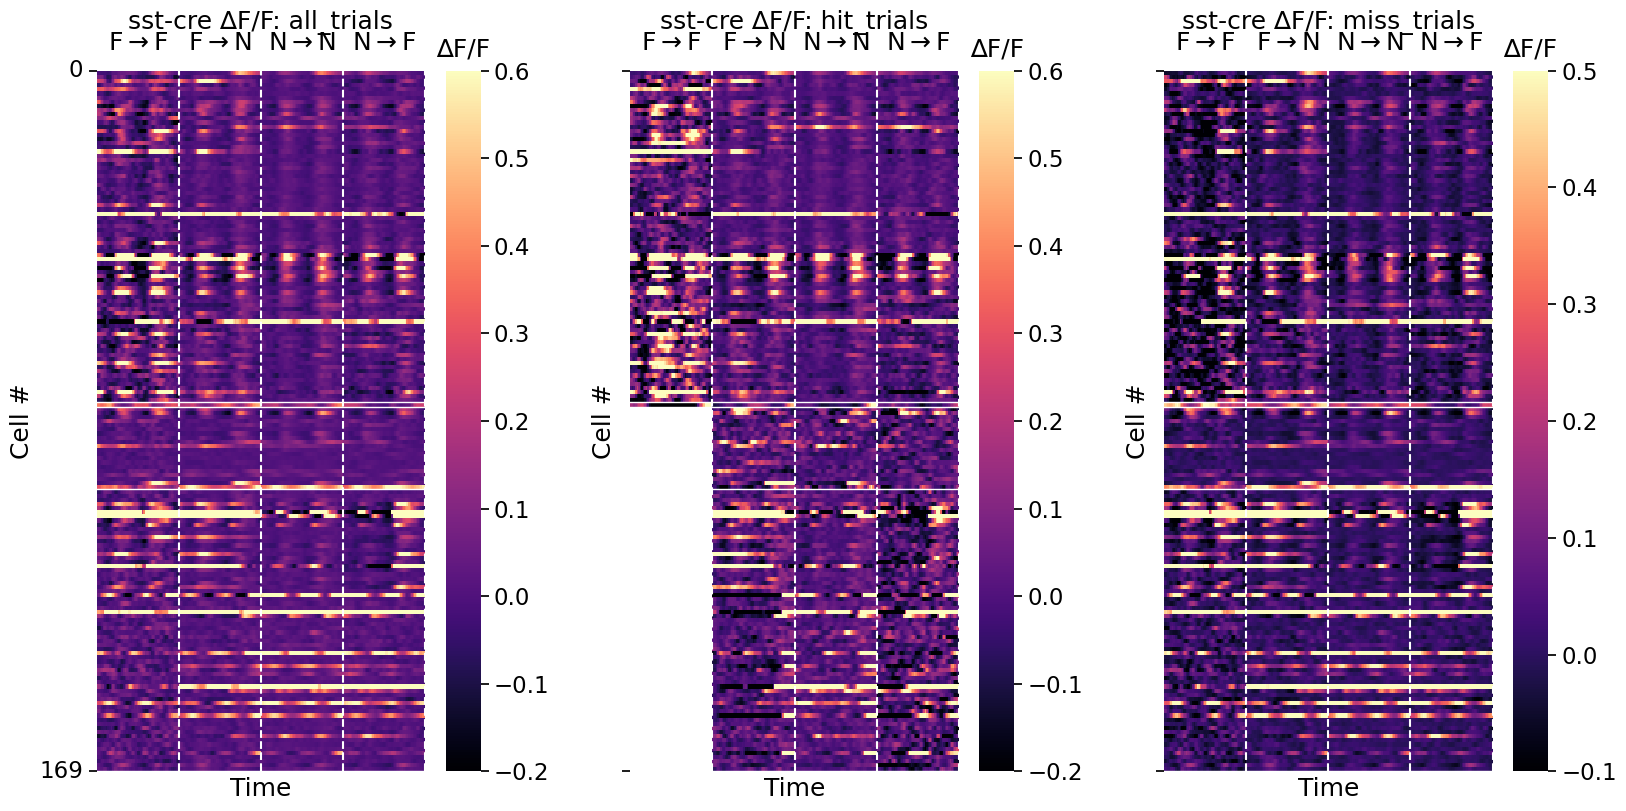

In [29]:
fig, axs = plt.subplots(1,3, sharey=True,
                        squeeze=False, #makes sure a 2D array of axs is always returned even if only 1 row/column
                        figsize = (16, 8), #have fig-size depend on number of companys/metrics
                        )
fig.tight_layout()

dff_flat_list = []


for n, dff_list in enumerate(dff_groups_list):
    dff_array = np.array(dff_list)
    
    dff_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)

    
    #name_list = [r'N$\rightarrow$N', r'N$\rightarrow$F', r'F$\rightarrow$F', r'F$\rightarrow$N']
    if n==2:
        sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0,n], vmin=-0.1, vmax=0.5)
    else:
        sp = sns.heatmap(dff_flat,cmap='magma', 
                         #cbar=False, 
                         ax=axs[0,n], vmin=dff_vmin, vmax=dff_vmax)
    
    # sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)

    cbar = plt.gcf().axes[-1] 
    cbar.set_title('∆F/F', pad=10)  # Horizontal label
    #cbar.ax.yaxis.set_label_position('left')  # Position the label above the colorbar
    
    line_offset = 0
    for i in range(4):
        timepts = dff_array.shape[-1]
        sp.axvline(timepts*(i+1), color='w', linestyle='--')
        sp.text(timepts*(i+1)-timepts/2, -5, name_list[i], horizontalalignment='center')
        

        temp_df = vip_stacked_dict[mouse_id_list[i]]
        cell_ct = len(temp_df.cell_specimen_id.unique())
        sp.axhline(cell_ct + line_offset, color='w', linewidth=1)
        line_offset = line_offset + cell_ct

    # line_offset = 0
    # for mouse_id in mouse_id_list:
    #     temp_df = vip_stacked_dict[mouse_id]
    #     cell_ct = len(temp_df.cell_specimen_id.unique())
    #     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
    #     line_offset = line_offset + cell_ct

    
    sp.set_title(f'{end_folder} ∆F/F: ' + groups_types_list[n], pad=30)
    sp.set_ylabel('Cell #');
    sp.set_yticks(ticks=cell_ticks, labels=cell_ticks);
    sp.set_xlabel('Time');
    sp.set_xticks(ticks=[], labels = [])
    
    dff_flat_list += [dff_flat]

# Save as SVG
plt.subplots_adjust(wspace=0.3, hspace=0.5)

if save_plots==True:
    plt.savefig(genotype_image_path+'unsorted_dff_heatmap.svg', format = "svg")
plt.show()

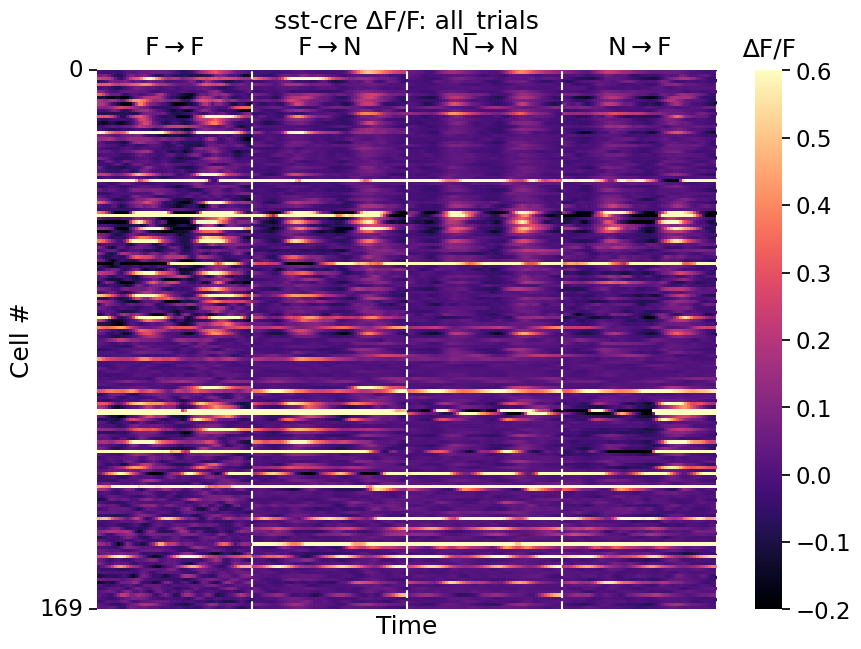

In [30]:
fig, axs = plt.subplots(sharey=True,
                        squeeze=False, #makes sure a 2D array of axs is always returned even if only 1 row/column
                        figsize = (10, 7), #have fig-size depend on number of companys/metrics
                        )
#3fig.tight_layout()

#dff_flat_list = []
dff_single_lists = [dff_all_list]

for n, dff_list in enumerate(dff_single_lists):
    dff_array = np.array(dff_list)
    
    dff_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)

    
    #name_list = [r'N$\rightarrow$N', r'N$\rightarrow$F', r'F$\rightarrow$F', r'F$\rightarrow$N']
    if n==2:
        sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0,n], vmin=-0.1, vmax=0.5)
    else:
        sp = sns.heatmap(dff_flat,cmap='magma', 
                         #cbar=False, 
                         ax=axs[0,n], vmin=dff_vmin, vmax=dff_vmax)
    
    # sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)

    cbar = plt.gcf().axes[-1] 
    cbar.set_title('∆F/F', pad=10)  # Horizontal label
    #cbar.ax.yaxis.set_label_position('left')  # Position the label above the colorbar
    
    line_offset = 0
    for i in range(4):
        timepts = dff_array.shape[-1]
        sp.axvline(timepts*(i+1), color='w', linestyle='--')
        sp.text(timepts*(i+1)-timepts/2, -5, name_list[i], horizontalalignment='center')
        

        temp_df = vip_stacked_dict[mouse_id_list[i]]
        cell_ct = len(temp_df.cell_specimen_id.unique())
        # sp.axhline(cell_ct + line_offset, color='w', linewidth=1)
        line_offset = line_offset + cell_ct

    # line_offset = 0
    # for mouse_id in mouse_id_list:
    #     temp_df = vip_stacked_dict[mouse_id]
    #     cell_ct = len(temp_df.cell_specimen_id.unique())
    #     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
    #     line_offset = line_offset + cell_ct

    
    sp.set_title(f'{end_folder} ∆F/F: ' + groups_types_list[n], pad=30)
    sp.set_ylabel('Cell #');
    sp.set_yticks(ticks=cell_ticks, labels=cell_ticks);
    sp.set_xlabel('Time');
    sp.set_xticks(ticks=[], labels = [])
    
    dff_flat_list += [dff_flat]

# Save as SVG
plt.subplots_adjust(wspace=0.3, hspace=0.5)

if save_plots==True:
    plt.savefig(genotype_image_path+'unsorted_dff_heatmap.svg', format = "svg")
plt.show()

In [31]:
# fig, axs = plt.subplots(1,3, sharey=True,
#                         squeeze=False, #makes sure a 2D array of axs is always returned even if only 1 row/column
#                         figsize = (20, 10), #have fig-size depend on number of companys/metrics
#                         )
# fig.tight_layout()

# for n, filtevent_list in enumerate(filtevent_groups_list):
#     filtevent_array = np.array(filtevent_list)
    
#     filtevent_flat = filtevent_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)    
    
#     #name_list = ['N-->N', 'N-->F', 'F-->F', 'F-->N']
#     if n==2:
#         sp = sns.heatmap(filtevent_flat,cmap='magma', ax=axs[0][n], 
#                          vmin=-0.025, vmax=0.15
#                         )
#     else:
#         sp = sns.heatmap(filtevent_flat,cmap='magma', 
#                          #cbar=False, 
#                          ax=axs[0][n], 
#                          vmin=-0.025, vmax=0.15
#                         )
    
#     # sp = sns.heatmap(events_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)

#     cbar = plt.gcf().axes[-1] 
#     cbar.set_title('events', pad=10)  # Horizontal label
#     #cbar.ax.yaxis.set_label_position('left')  # Position the label above the colorbar
    
#     line_offset = 0
#     for i in range(4):
#         timepts = filtevent_array.shape[-1]
#         sp.axvline(timepts*(i+1), color='w', linestyle='--')
#         sp.text(timepts*(i+1)-timepts/2, -10, name_list[i], horizontalalignment='center')
        

#         temp_df = vip_stacked_dict[mouse_id_list[i]]
#         cell_ct = len(temp_df.cell_specimen_id.unique())
#         sp.axhline(cell_ct + line_offset, color='w', linewidth=1)
#         line_offset = line_offset + cell_ct

#     # line_offset = 0
#     # for mouse_id in mouse_id_list:
#     #     temp_df = vip_stacked_dict[mouse_id]
#     #     cell_ct = len(temp_df.cell_specimen_id.unique())
#     #     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
#     #     line_offset = line_offset + cell_ct

    
#     sp.set_title(f'{end_folder} events image transitions: ' + groups_types_list[n], pad=30)
#     sp.set_ylabel('Cell #');
#     sp.set_xlabel('Time');

# # Save as SVG

# plt.savefig(image_path+'filtevents_heatmap_'+curr_name_svg, format="svg")

    

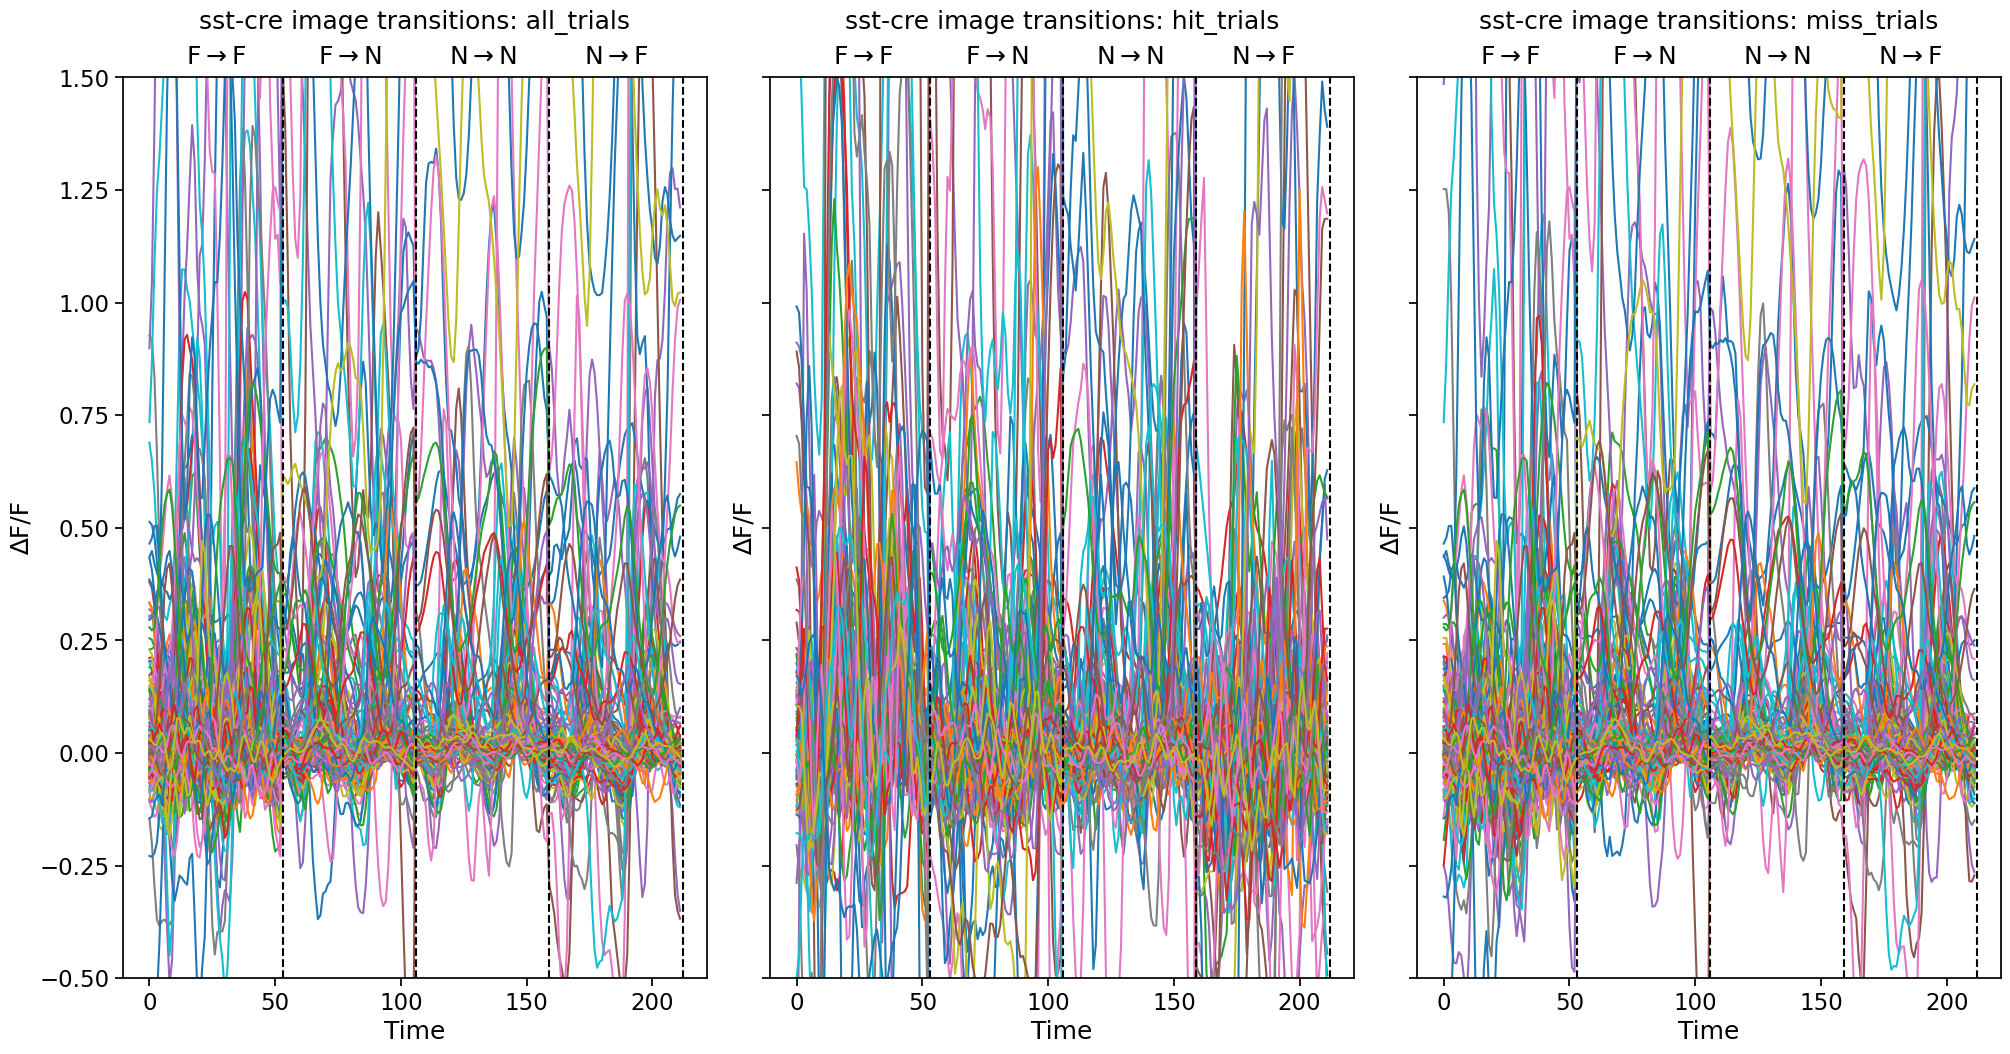

In [32]:
# Create a 1x3 subplot
fig, axs = plt.subplots(1, 3, figsize=(20, 10), sharey=True)
fig.tight_layout()

# Loop over dff_groups_list and plot each on a different subplot
for n, dff_array in enumerate(dff_groups_list):
    dff_array = np.array(dff_groups_list[n])
    dff_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()), -1)

    axs[n].plot(dff_flat.T)

    for i in range(4):
        timepts = dff_array.shape[-1]
        axs[n].axvline(timepts * (i + 1), color='k', linestyle='--')

        # Get the y-limit of the current subplot
        plt.ylim([dff_min, dff_max])
        ylim = axs[n].get_ylim()
        upper_ylim = ylim[1]

        # Add the text labels
        axs[n].text(timepts * (i + 1) - timepts / 2, upper_ylim + 0.03, name_list[i], 
                    horizontalalignment='center')

    # Set the title, ylabel, and xlabel for each subplot
    axs[n].set_title(f'{end_folder} image transitions: ' + groups_types_list[n], pad=35)
    axs[n].set_ylabel('∆F/F')
    axs[n].set_xlabel('Time')

# Save the entire figure as an SVG (optional)
if save_plots==True:
    plt.savefig(genotype_image_path+'unsorted_dff_traces.svg', format = "svg")

# Display the plot
plt.show()

# Z score the data

In [33]:
# dff_flat_list contains np flattened arrays for 0: all trials, 1: hit trials, and 2: miss trials
#dff_concat = np.hstack((dff_flat_list[0], dff_flat_list[2]))
dff_concat = np.array(dff_flat_list[0])
dff_hit_concat = np.array(dff_flat_list[1])
dff_miss_concat = np.array(dff_flat_list[2])

In [34]:
dff_concat.shape

(169, 212)

In [35]:
z_data_flat = stats.zscore(dff_concat,axis=1,nan_policy='omit')
z_data_hit = stats.zscore(dff_hit_concat,axis=1,nan_policy='omit')
z_data_miss = stats.zscore(dff_miss_concat,axis=1,nan_policy='omit')

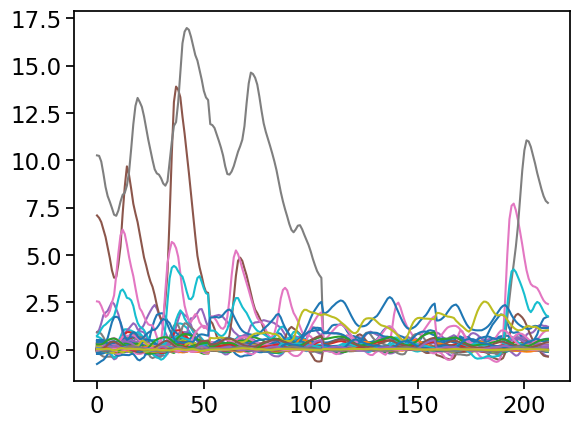

In [36]:
plt.plot(dff_concat.T);

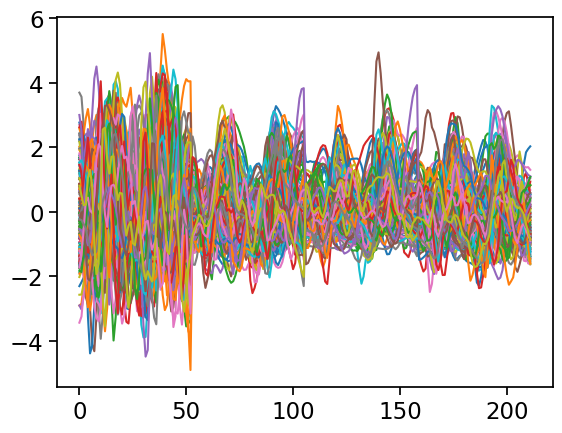

In [37]:
plt.plot(z_data_flat.T);

# Silhouette Score

In [38]:
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy as np

from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_samples, silhouette_score


## assign which data to cluster

In [39]:
data_to_cluster = z_data_flat

In [40]:
sns.color_palette("tab20c",20)

[(0.19215686274509805, 0.5098039215686274, 0.7411764705882353),
 (0.4196078431372549, 0.6823529411764706, 0.8392156862745098),
 (0.6196078431372549, 0.792156862745098, 0.8823529411764706),
 (0.7764705882352941, 0.8588235294117647, 0.9372549019607843),
 (0.9019607843137255, 0.3333333333333333, 0.050980392156862744),
 (0.9921568627450981, 0.5529411764705883, 0.23529411764705882),
 (0.9921568627450981, 0.6823529411764706, 0.4196078431372549),
 (0.9921568627450981, 0.8156862745098039, 0.6352941176470588),
 (0.19215686274509805, 0.6392156862745098, 0.32941176470588235),
 (0.4549019607843137, 0.7686274509803922, 0.4627450980392157),
 (0.6313725490196078, 0.8509803921568627, 0.6078431372549019),
 (0.7803921568627451, 0.9137254901960784, 0.7529411764705882),
 (0.4588235294117647, 0.4196078431372549, 0.6941176470588235),
 (0.6196078431372549, 0.6039215686274509, 0.7843137254901961),
 (0.7372549019607844, 0.7411764705882353, 0.8627450980392157),
 (0.8549019607843137, 0.8549019607843137, 0.9215686274509803),
 (0.38823529411764707, 0.38823529411764707, 0.38823529411764707),
 (0.5882352941176471, 0.5882352941176471, 0.5882352941176471),
 (0.7411764705882353, 0.7411764705882353, 0.7411764705882353),
 (0.8509803921568627, 0.8509803921568627, 0.8509803921568627)]

In [41]:
color_map = sns.color_palette("tab20b_r",20)
colors_clusters = [c for i, c in enumerate(color_map) if i in np.array([5,9,13,17])]

In [42]:
if end_folder == 'slc17a7-cre':
    color_map = sns.color_palette("tab20b_r",20)
    colors_clusters = [c for i, c in enumerate(color_map) if i in np.array([0,2,5,9,12,14,17])]

In [43]:
sns.color_palette("terrain",12)

[(0.10065359477124183, 0.39869281045751637, 0.7986928104575164),
 (0.0, 0.6058823529411764, 0.9823529411764705),
 (0.0, 0.7627450980392158, 0.5117647058823529),
 (0.2235294117647059, 0.8447058823529412, 0.4447058823529412),
 (0.5372549019607841, 0.9074509803921569, 0.5074509803921569),
 (0.8509803921568627, 0.9701960784313726, 0.5701960784313725),
 (0.9254901960784314, 0.9046274509803922, 0.5597647058823529),
 (0.7686274509803921, 0.7038431372549019, 0.47505882352941176),
 (0.611764705882353, 0.5030588235294118, 0.39035294117647057),
 (0.5372549019607841, 0.4076862745098036, 0.3799215686274507),
 (0.6941176470588235, 0.6084705882352941, 0.5901176470588235),
 (0.8509803921568627, 0.8092549019607842, 0.800313725490196)]

In [44]:
color_map2 = sns.color_palette("terrain",12)
colors_structures = [c for i, c in enumerate(color_map2) if i in np.array([1,3,5,8])]

## Calculate silhouette score

For n_clusters = 2 The average silhouette_score is : 0.17964754785225343
For n_clusters = 3 The average silhouette_score is : 0.13737595474352396
For n_clusters = 4 The average silhouette_score is : 0.09566994306207262
For n_clusters = 5 The average silhouette_score is : 0.09196795755718655
For n_clusters = 6 The average silhouette_score is : 0.0909970203208477
For n_clusters = 7 The average silhouette_score is : 0.09161142390634744
For n_clusters = 8 The average silhouette_score is : 0.08997353223007823
For n_clusters = 9 The average silhouette_score is : 0.09054822376559483
For n_clusters = 10 The average silhouette_score is : 0.08771712378142812
For n_clusters = 11 The average silhouette_score is : 0.09545486191072175


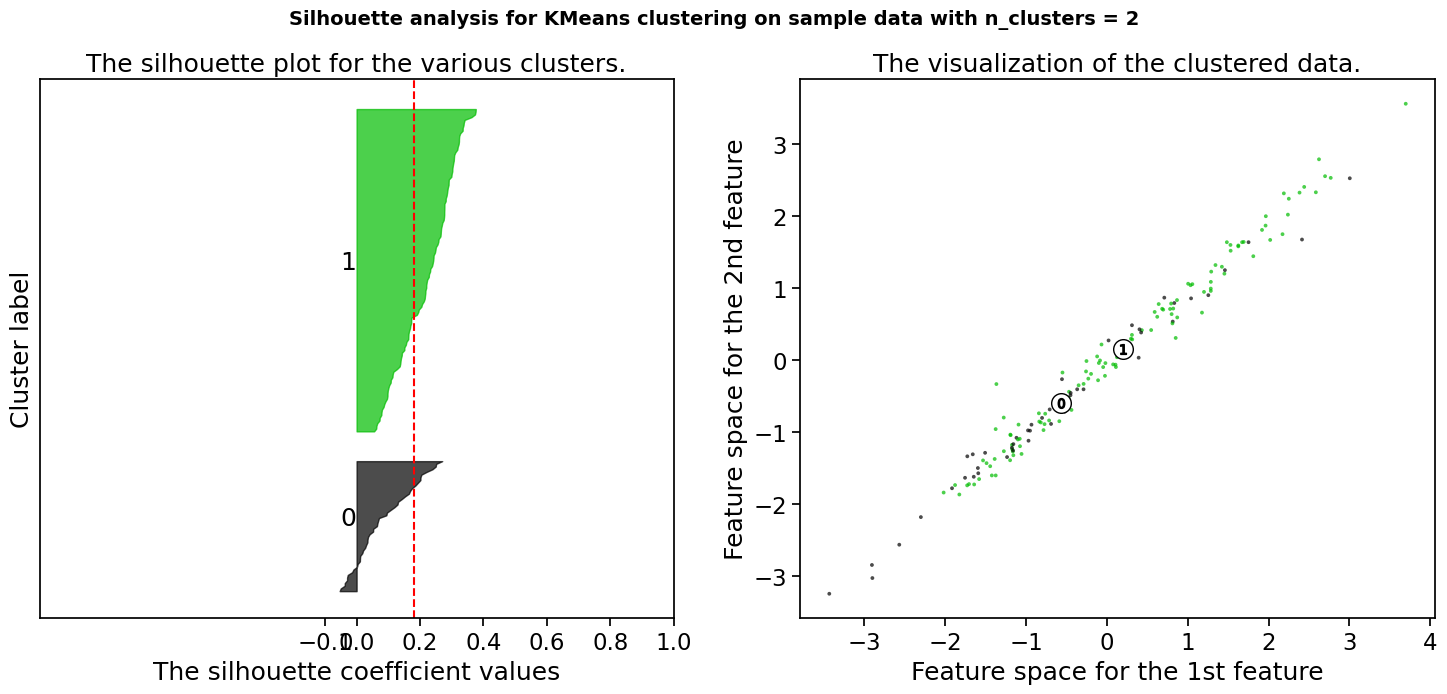

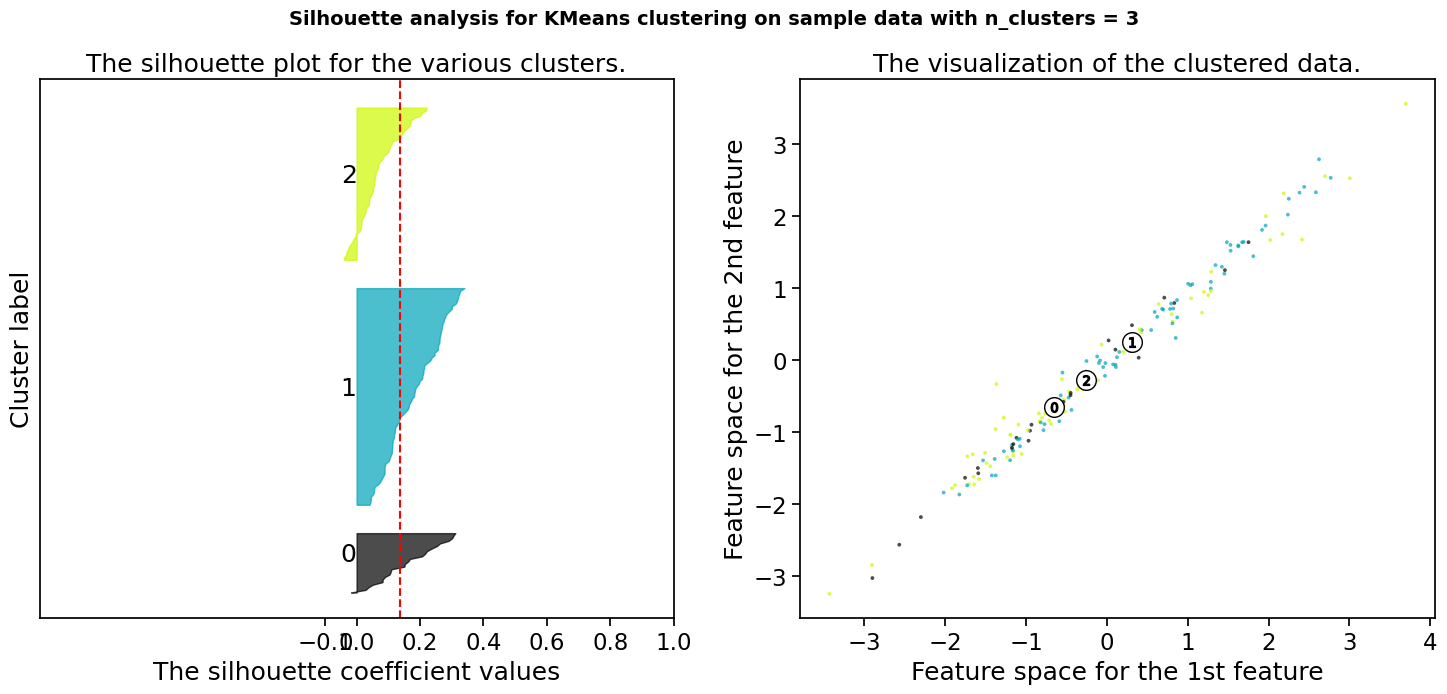

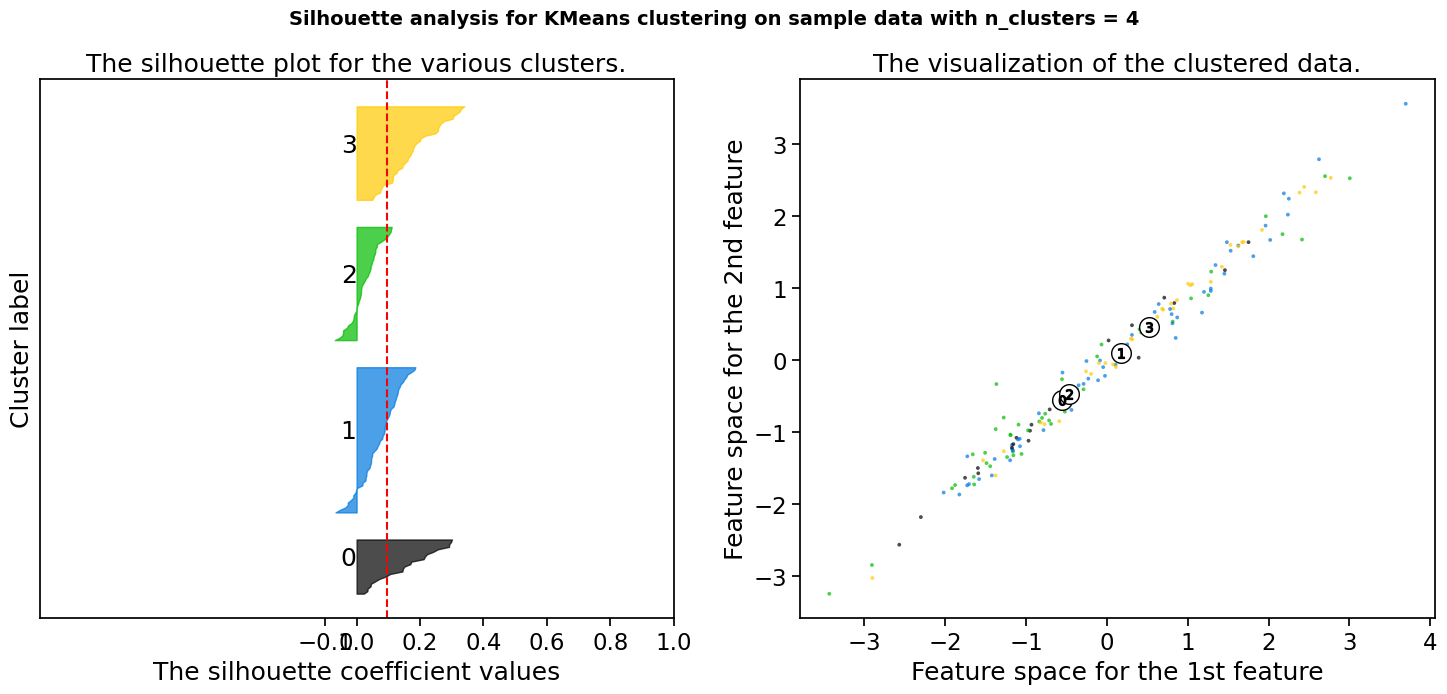

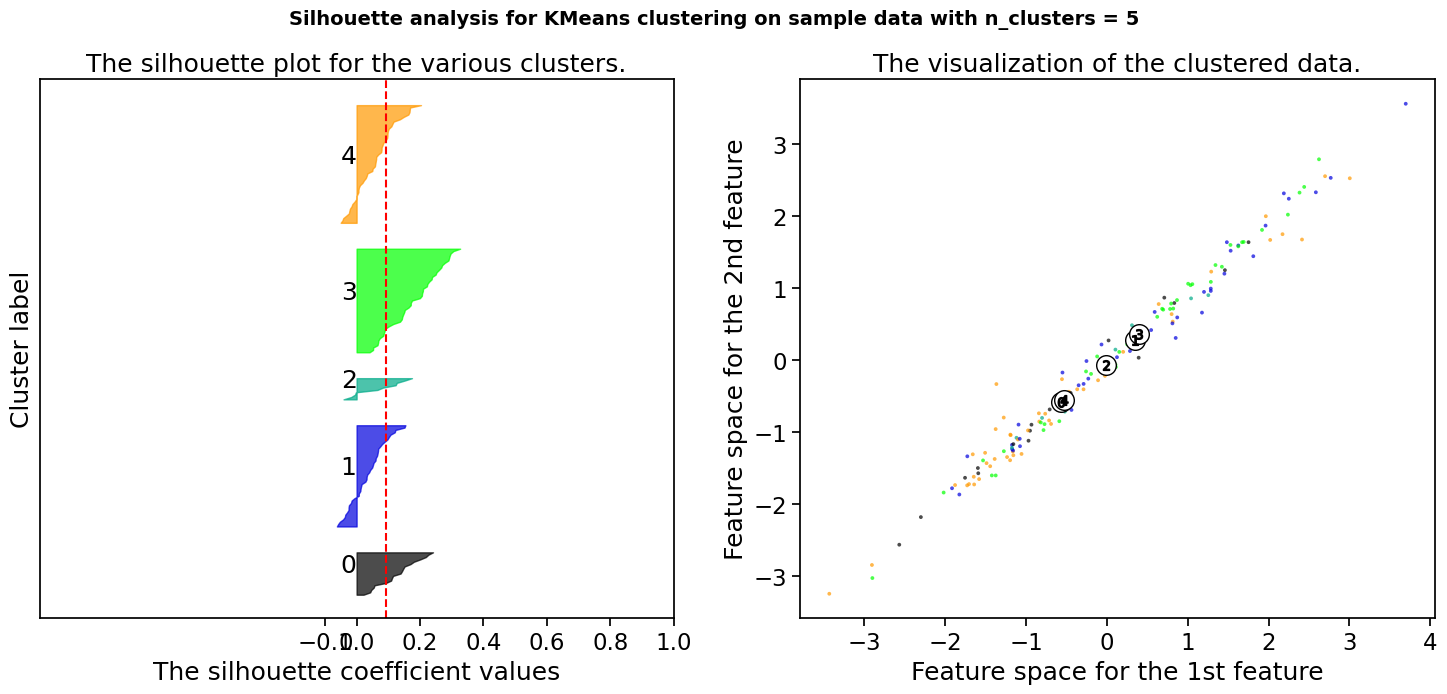

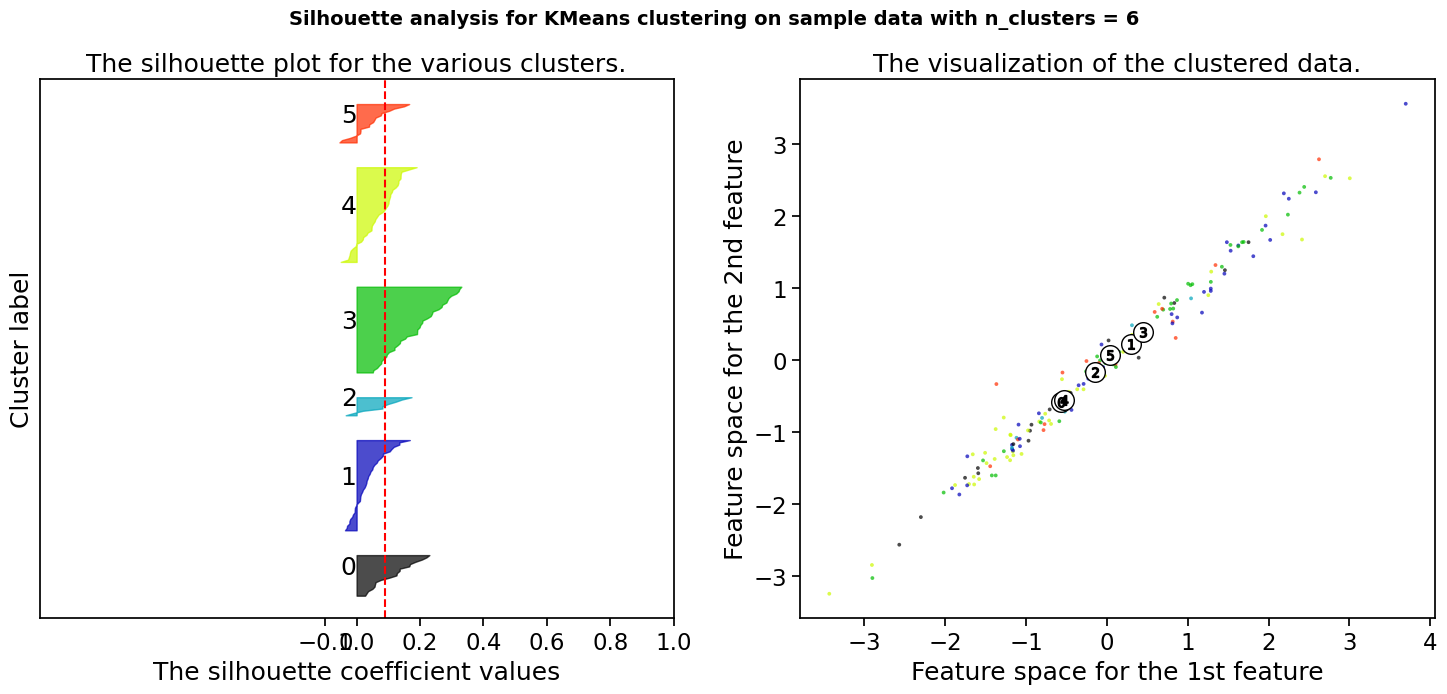

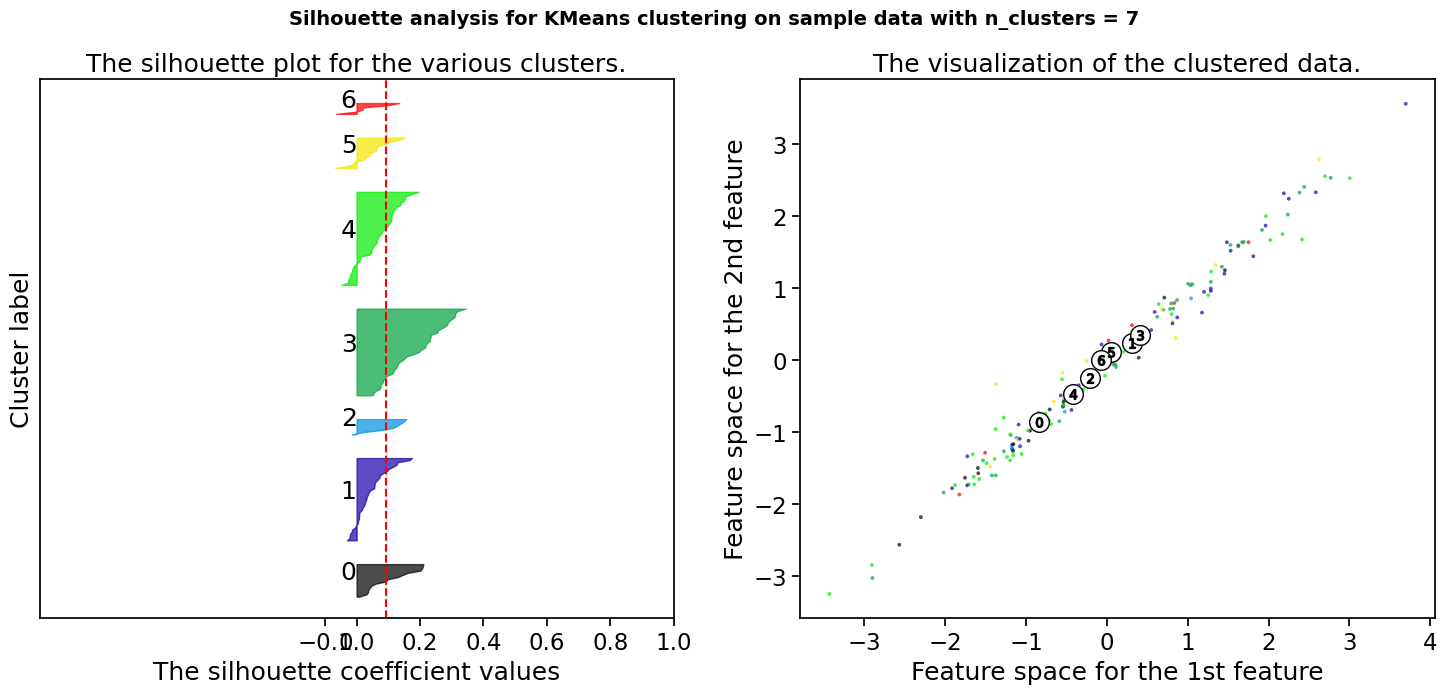

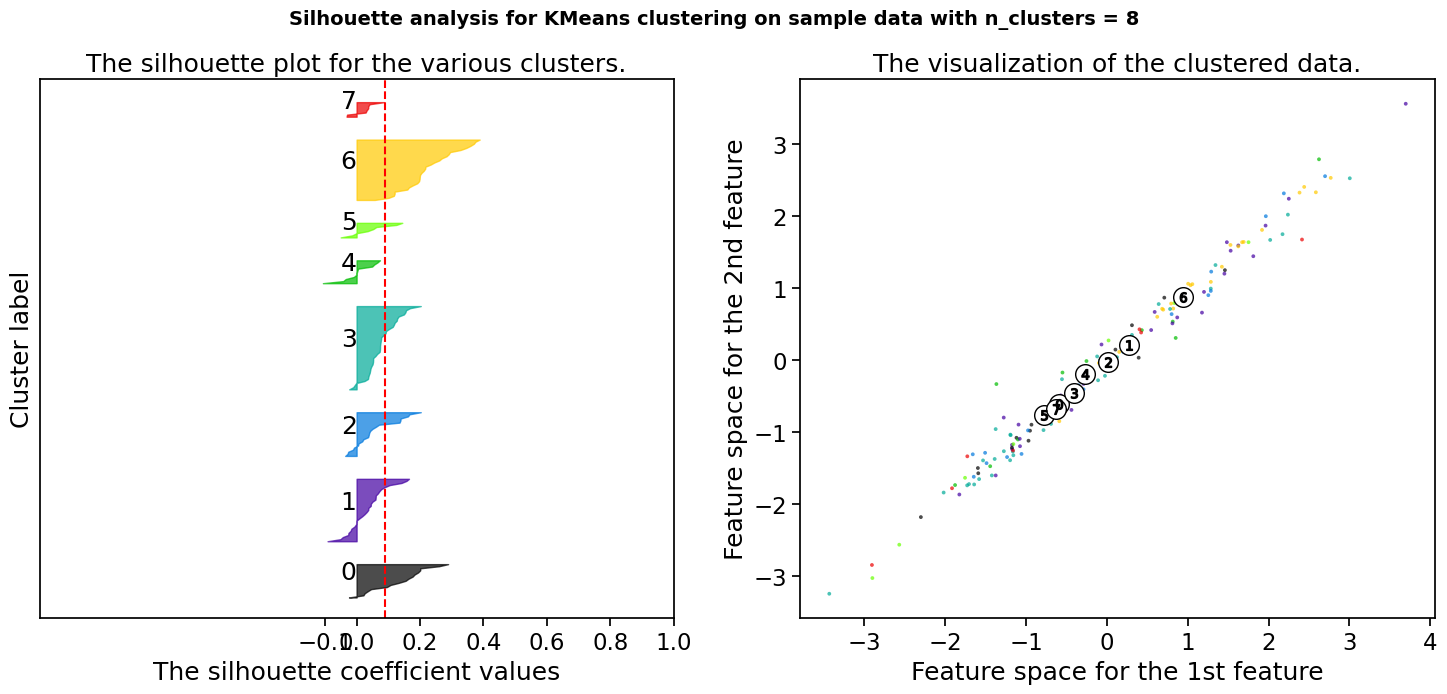

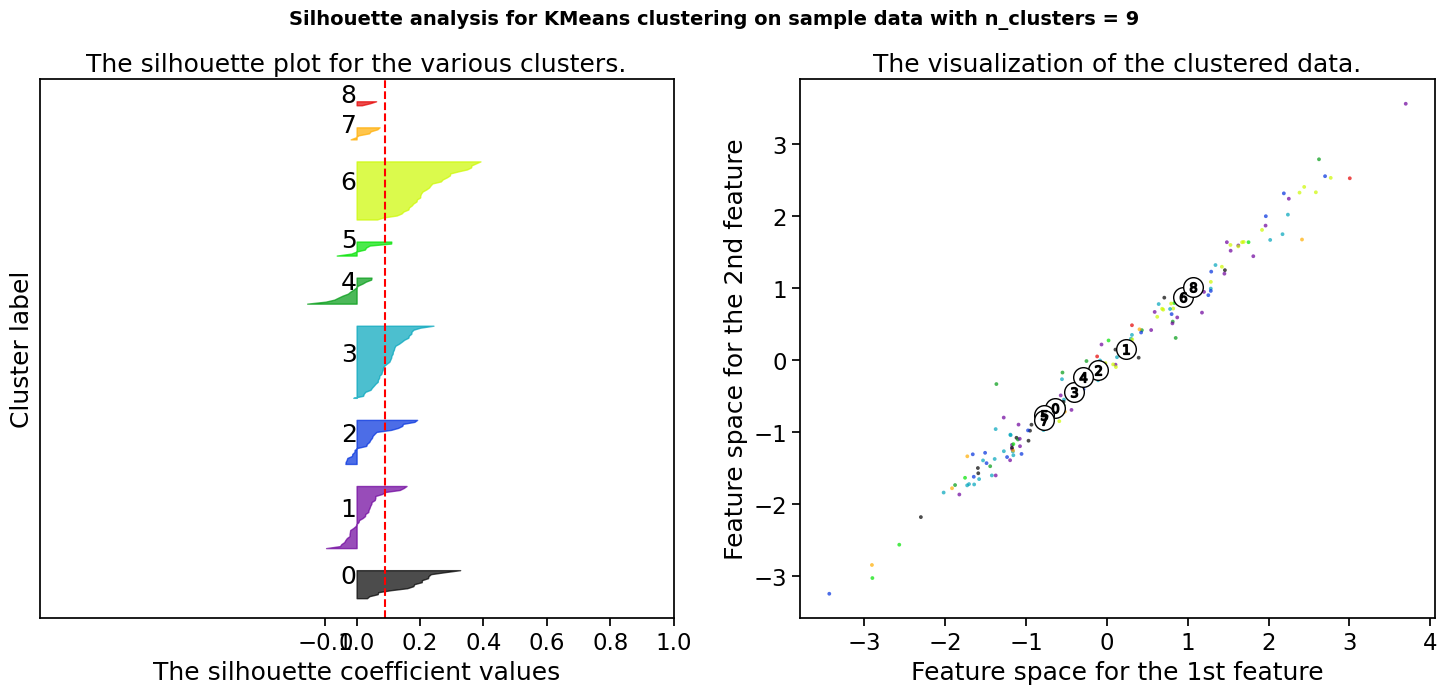

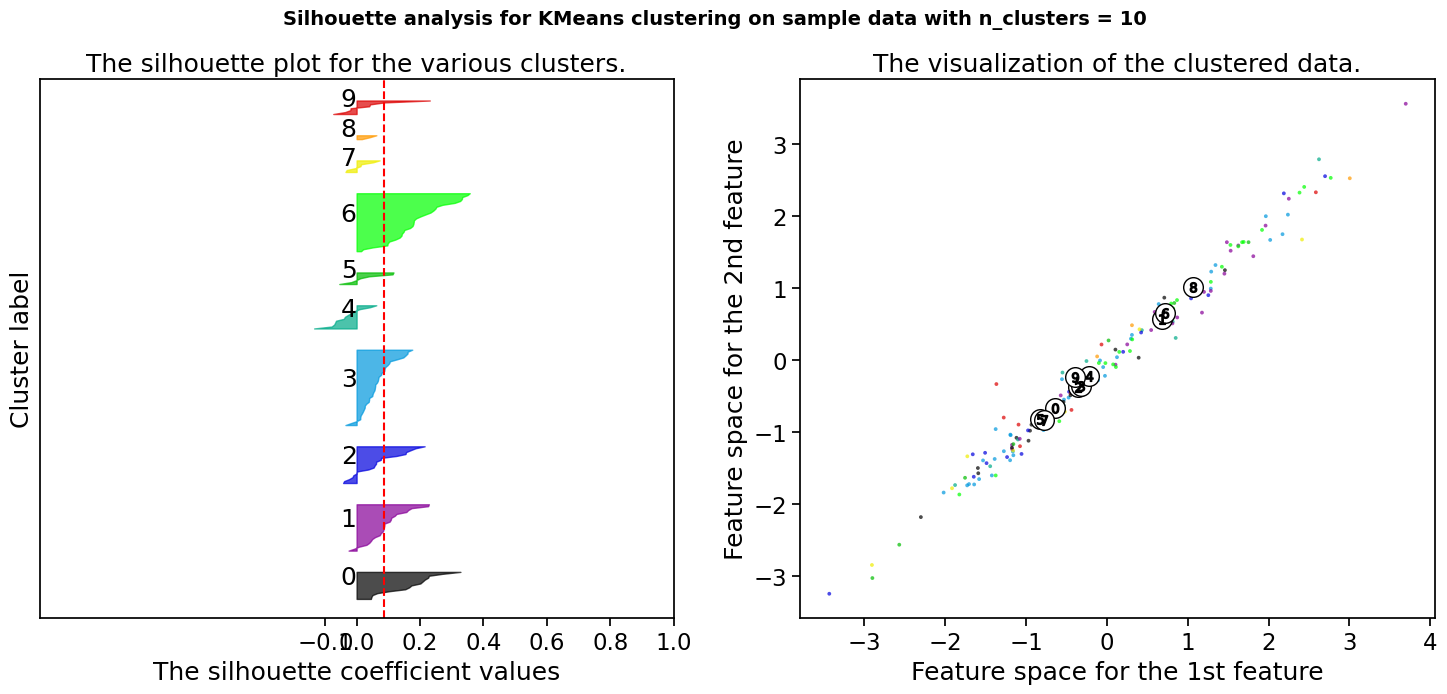

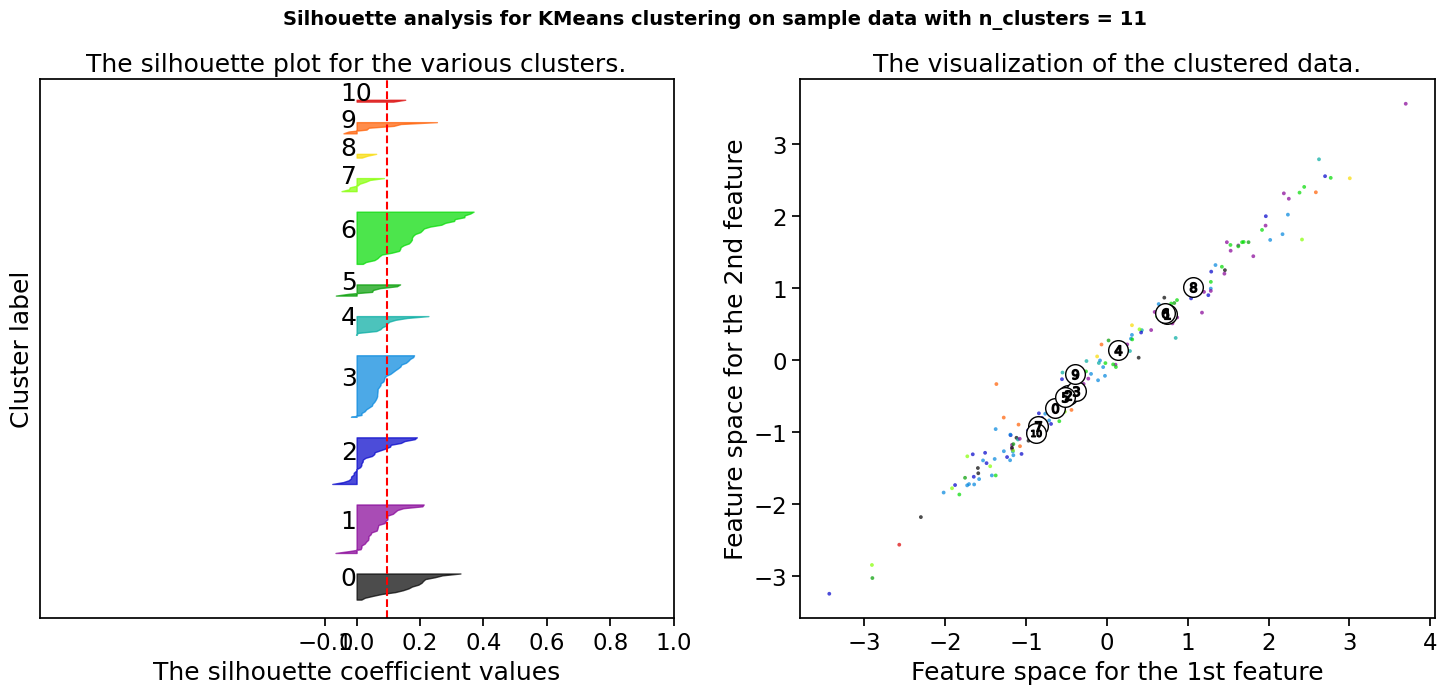

In [45]:


# Generating the sample data from make_blobs
# This particular setting has one distinct cluster and 3 clusters placed close
# together.
# X, y = make_blobs(
#     n_samples=500,
#     n_features=2,
#     centers=4,
#     cluster_std=1,
#     center_box=(-10.0, 10.0),
#     shuffle=True,
#     random_state=1,
# )  # For reproducibility

range_n_clusters = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]
silhouette_list = []
for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(data_to_cluster) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(data_to_cluster)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(data_to_cluster, cluster_labels)
    print(
        "For n_clusters =",
        n_clusters,
        "The average silhouette_score is :",
        silhouette_avg,
    )
    silhouette_list.append(silhouette_avg)
    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(data_to_cluster, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_values,
            facecolor=color,
            edgecolor=color,
            alpha=0.7,
        )

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(
        data_to_cluster[:, 0], data_to_cluster[:, 1], marker=".", s=30, lw=0, alpha=0.7, c=colors, edgecolor="k"
    )

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(
        centers[:, 0],
        centers[:, 1],
        marker="o",
        c="white",
        alpha=1,
        s=200,
        edgecolor="k",
    )

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker="$%d$" % i, alpha=1, s=50, edgecolor="k")

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(
        "Silhouette analysis for KMeans clustering on sample data with n_clusters = %d"
        % n_clusters,
        fontsize=14,
        fontweight="bold",
    )

plt.show()

Text(0, 0.5, 'Silhouette score')

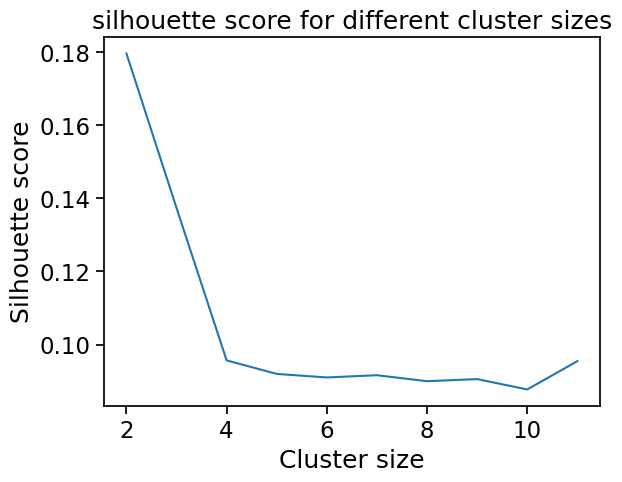

In [46]:
# plot silhouette scores:
#sil_scores = [0.05678667949056855, 0.0503501752731177, 0.04842927896017404, 0.04119648460883629, 0.03887885728616518, 0.04372803573890765, 0.040548893560572445]
clus_num = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11]

plt.plot(clus_num, silhouette_list)
plt.title("silhouette score for different cluster sizes")
plt.xlabel("Cluster size")
plt.ylabel("Silhouette score")

# K Means Clustering WITH PCA

In [47]:
# Assign the number of clusters
num_clusters = 4

In [48]:
import random


pca = PCA(2)

#Transform the data
df_kmeans = pca.fit_transform(data_to_cluster)
 
df_kmeans.shape

(169, 2)

In [49]:


kmeans = KMeans(n_clusters= num_clusters, random_state = 50)
 
#predict the labels of clusters.
label = kmeans.fit_predict(df_kmeans)
 


In [50]:
#kmeans = KMeans(n_clusters=num_clusters).fit(data_to_cluster)


In [51]:
# for cell_specimen_id in stim_response_stack_nn.cell_specimen_id.unique()

# Get the unique cell_specimen_ids
unique_cell_ids = stim_response_stack_nn.cell_specimen_id.unique()

# Initialize an empty list to store the targeted_structure_id values
structure_ids = []

cell_id_list_2 = []

# Loop through each unique cell_specimen_id
for cell_specimen_id in unique_cell_ids:
    # Get the targeted_structure_id for the current cell_specimen_id
    # Assuming that each cell_specimen_id is associated with only one targeted_structure_id
    targeted_structure_id = stim_response_stack_nn.loc[stim_response_stack_nn.cell_specimen_id == cell_specimen_id, 'targeted_structure_id'].iloc[0]
    
    # Append the targeted_structure_id to the list
    structure_ids.append(targeted_structure_id)
    cell_id_list_2.append(cell_specimen_id)

# Convert the list to an ndarray
structure_ids_array = np.array(structure_ids)


In [52]:
cell_id_list == cell_id_list_2

True

## Convert back to data frame

In [53]:
# Convert each row of the array to a list
z_all_list = [list(row) for row in z_data_flat]

# Convert each row of the array to a list
z_hit_list = [list(row) for row in z_data_hit]

# Convert each row of the array to a list
z_miss_list = [list(row) for row in z_data_miss]

df_kmeans_list = [list(row) for row in df_kmeans]

In [54]:
clustered_df = pd.DataFrame(
{"targeted_structure_id" : structure_ids,
"cell_specimen_id" : cell_id_list, "df_kmeans" : df_kmeans_list, "z_all" : z_all_list, "z_hit" : z_hit_list, "z_miss" : z_miss_list})


In [55]:
len(kmeans.labels_)

169

In [56]:
clustered_df['kmeans_labels_unsorted'] = kmeans.labels_


In [57]:
clustered_df['dff_all'] = dff_all_list
clustered_df['dff_hit'] = dff_hit_list
clustered_df['dff_miss'] = dff_miss_list
#clustered_df['z_all'] = z_data_flat


In [58]:
# Group by cell_specimen_id and calculate the mean of dff_mean_response
mean_dff_nn = stim_response_stack_nn.groupby('cell_specimen_id')['dff_mean_response'].mean()

# Map these means back to the original DataFrame
clustered_df['dff_mean_nn'] = clustered_df['cell_specimen_id'].map(mean_dff_nn)

In [59]:
# Group by cell_specimen_id and calculate the mean of dff_mean_response
mean_dff_nf = stim_response_stack_nf.groupby('cell_specimen_id')['dff_mean_response'].mean()

# Map these means back to the original DataFrame
clustered_df['dff_mean_nf'] = clustered_df['cell_specimen_id'].map(mean_dff_nf)

In [60]:
# Group by cell_specimen_id and calculate the mean of dff_mean_response
mean_dff_ff = stim_response_stack_ff.groupby('cell_specimen_id')['dff_mean_response'].mean()

# Map these means back to the original DataFrame
clustered_df['dff_mean_ff'] = clustered_df['cell_specimen_id'].map(mean_dff_ff)

In [61]:
# Group by cell_specimen_id and calculate the mean of dff_mean_response
mean_dff_fn = stim_response_stack_fn.groupby('cell_specimen_id')['dff_mean_response'].mean()

# Map these means back to the original DataFrame
clustered_df['dff_mean_fn'] = clustered_df['cell_specimen_id'].map(mean_dff_fn)

In [62]:
# cluster_sizes

NameError: name 'cluster_sizes' is not defined

In [63]:
cluster_sizes = clustered_df.value_counts('kmeans_labels_unsorted', ascending=True, sort=True)
size_sorted_labels = np.argsort(cluster_sizes)
size_sorted_labels

kmeans_labels_unsorted
2    0
1    1
0    2
3    3
dtype: int64

In [64]:
cluster_sizes

kmeans_labels_unsorted
2    22
1    40
0    51
3    56
dtype: int64

In [65]:
new_cluster_labels = dict(np.argsort(cluster_sizes))

In [66]:
new_cluster_labels

{2: 0, 1: 1, 0: 2, 3: 3}

In [67]:
clustered_df['kmeans_labels'] = [new_cluster_labels[cluster_id] for cluster_id in clustered_df.kmeans_labels_unsorted.values]

In [68]:
clustered_df[['kmeans_labels', 'kmeans_labels_unsorted']]

kmeans_labels  kmeans_labels_unsorted
0                3                       3
1                2                       0
2                2                       0
3                1                       1
4                2                       0
..             ...                     ...
164              0                       2
165              2                       0
166              1                       1
167              2                       0
168              1                       1

[169 rows x 2 columns]

In [69]:
sorted_clustered_df = clustered_df.sort_values(by=['kmeans_labels', 'targeted_structure_id'])


In [70]:
# X = data_to_cluster
# y = structure_ids_array

# Plot K Means Clusters

In [71]:
u_labels = np.unique(label)
u_labels

array([0, 1, 2, 3], dtype=int32)

In [72]:
u_labels = np.unique(label)
u_labels = np.array(list(new_cluster_labels.keys()))
u_labels

array([2, 1, 0, 3])

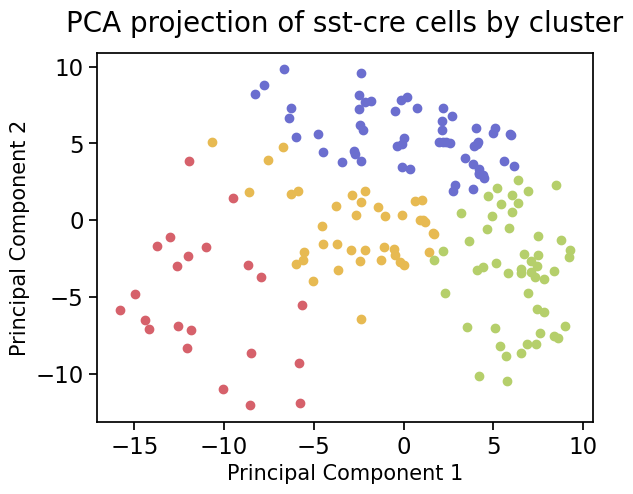

In [73]:
#Getting unique labels
 
#u_labels = np.unique(label)
u_labels = np.array(list(new_cluster_labels.keys()))
 
#plotting the results:
hues = sns.color_palette("Dark2")
 
for i,clus in enumerate(u_labels):
    plt.scatter(df_kmeans[label == clus , 0] , df_kmeans[label == clus , 1] , label = i+1, color = colors_clusters[i])
#plt.legend(title='Cluster', loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('PCA projection of ' + end_folder + ' cells by cluster', fontsize = 20, pad = 15)

if save_plots==True:
    plt.savefig(genotype_image_path+'PCA_by_clusters.svg', format = "svg")
plt.show()

In [74]:
# #Getting unique labels
 
# u_labels = np.unique(label)
 
# #plotting the results:
# hues = sns.color_palette("Dark2")
 
# for i in u_labels:
#     plt.scatter(df_kmeans[label == i , 0] , df_kmeans[label == i , 1] , label = i+1, color = colors_clusters[i])
# plt.legend(title='Cluster', loc='center left', bbox_to_anchor=(1, 0.5))

# plt.xlabel('Principal Component 1', fontsize = 15)
# plt.ylabel('Principal Component 2', fontsize = 15)
# plt.title('PCA projection of ' + end_folder + ' cells by cluster', fontsize = 20, pad = 15)


# plt.savefig(genotype_image_path+'PCA_by_clusters', format = "svg")
# plt.show()

# Compute Correlation Matrix

In [75]:
cluster_totals = sorted_clustered_df.groupby('kmeans_labels').count()['cell_specimen_id']
cluster_totals

kmeans_labels
0    22
1    40
2    51
3    56
Name: cell_specimen_id, dtype: int64

## Cluster-sorted Correlation Matrix

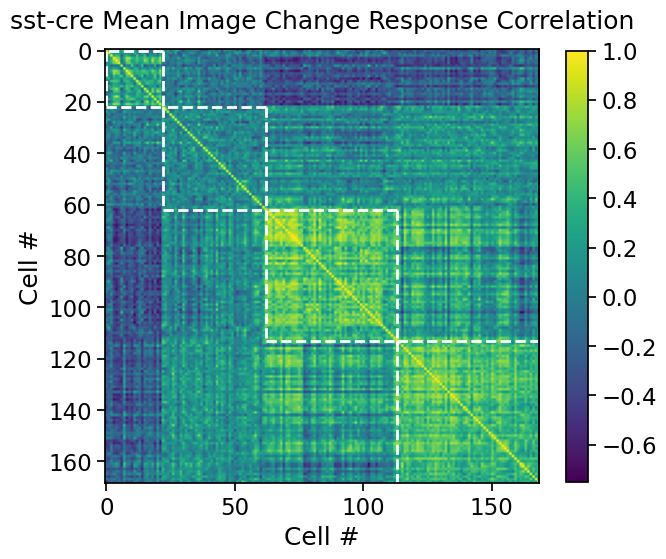

In [76]:
#compute correlation matrix
population_activity_correlation1 = np.array(sorted_clustered_df.z_all.tolist())
    
population_activity_correlation = population_activity_correlation1.reshape(len(sorted_clustered_df.cell_specimen_id.unique()),-1)
corr_matrix = np.corrcoef(population_activity_correlation)
#plot
# Calculate cluster totals and cumulative sums
cluster_totals = sorted_clustered_df.groupby('kmeans_labels').count()['cell_specimen_id']
cumulative_sums = np.cumsum(cluster_totals)

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(7, 7))
img = ax.imshow(corr_matrix, cmap='viridis')

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Plot lines for each cluster total, controlling where they start and end
for i in range(len(cumulative_sums)):
    start = 0 if i == 0 else cumulative_sums[i-1]
    end = cumulative_sums[i]
    ax.plot([start, end], [end, end], color='w', linestyle = '--', linewidth=2)  # Horizontal line
    ax.plot([end, end], [start, end], color='w', linestyle = '--', linewidth=2)  # Vertical line
    
    ax.plot([start, start], [start, end], color='w', linestyle = '--', linewidth=2)
    ax.plot([end, start], [start, start], color='w', linestyle = '--', linewidth=2)

# Add colorbar
#plt.colorbar(img, ax=ax, shrink=0.8)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Cell #')
ax.set_ylabel('Cell #')
ax.set_title(end_folder + ' Mean Image Change Response Correlation', pad=15) 

   
# Add colorbar
plt.colorbar(img, ax=ax, shrink=0.8)

if save_plots==True:
    plt.savefig(genotype_image_path+'cell_correlation_imagechange.svg', format = "svg")


plt.show()

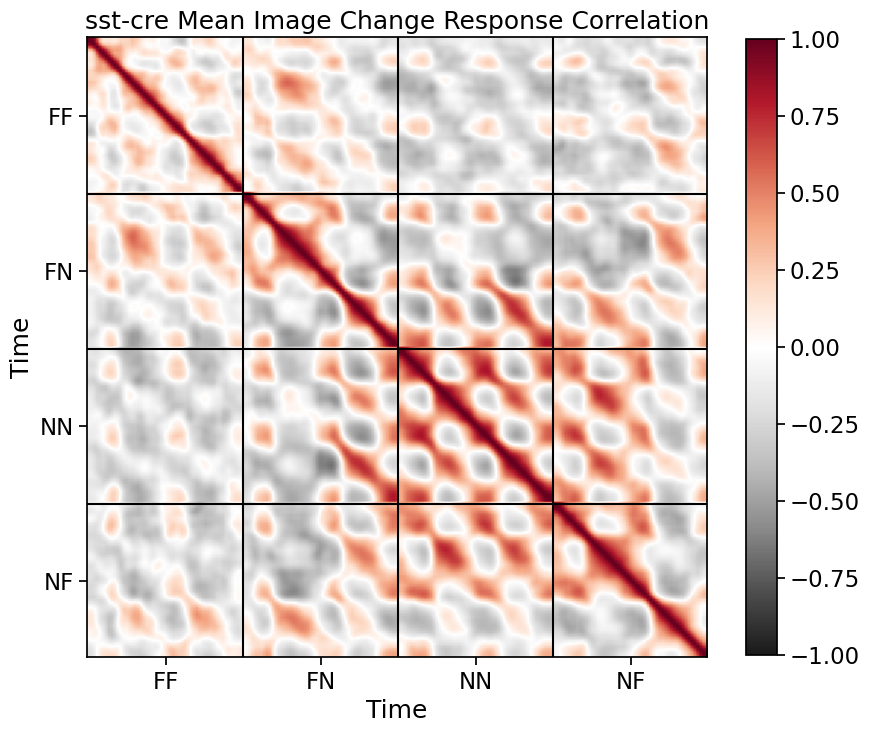

In [77]:
#compute correlation matrix
population_activity_correlation1 = np.array(sorted_clustered_df.z_all.tolist())
    
population_activity_correlation = population_activity_correlation1.reshape(len(sorted_clustered_df.cell_specimen_id.unique()),-1)
corr_matrix = np.corrcoef(population_activity_correlation.T)
#plot
# Calculate cluster totals and cumulative sums
cluster_totals = sorted_clustered_df.groupby('kmeans_labels').count()['cell_specimen_id']
cumulative_sums = np.cumsum(cluster_totals)

# Plot the correlation matrix
fig, ax = plt.subplots(figsize=(10, 10))
img = ax.imshow(corr_matrix, cmap='RdGy_r', vmin =-1, vmax=1)

xlim = ax.get_xlim()
ylim = ax.get_ylim()

# Plot lines for each cluster total, controlling where they start and end
# for i in range(len(cumulative_sums)):
#     start = 0 if i == 0 else cumulative_sums[i-1]
#     end = cumulative_sums[i]
#     ax.plot([start, end], [end, end], color='white', linestyle='--', linewidth=1.5)  # Horizontal line
#     ax.plot([end, end], [start, end], color='white', linestyle='--', linewidth=1.5)  # Vertical line
    
#     ax.plot([start, start], [start, end], color='white', linestyle='--', linewidth=1.5)  
#     ax.plot([end, start], [start, start], color='white', linestyle='--', linewidth=1.5)  

# Add colorbar
#plt.colorbar(img, ax=ax, shrink=0.8)
ax.set_xlim(xlim)
ax.set_ylim(ylim)
ax.set_xlabel('Time')
ax.set_ylabel('Time')
ax.set_title(end_folder + ' Mean Image Change Response Correlation') 



for i in range(4):
    plt.axvline(53*(i+1), color='k')
    plt.axhline(53*(i+1), color='k')
plt.xticks([53*(i)+53/2 for i in range(4)], ['FF','FN','NN','NF'], rotation=0)
plt.yticks([53*(i)+53/2 for i in range(4)], ['FF','FN','NN','NF']);

   
# Add colorbar
plt.colorbar(img, ax=ax, shrink=0.8)


if save_plots==True:
    plt.savefig(genotype_image_path+'changetype_correlation_imagechange.svg', format = "svg")


plt.show()

## Region-sorted Correlation Matrix

In [78]:
region_sorted_clustered_df = clustered_df.sort_values(by=['targeted_structure_id', 'kmeans_labels'])


In [79]:
cumulative_sums

kmeans_labels
0     22
1     62
2    113
3    169
Name: cell_specimen_id, dtype: int64

In [80]:
# #compute correlation matrix
# population_activity_correlation1 = np.array(region_sorted_clustered_df.z_all.tolist())
    
# population_activity_correlation = population_activity_correlation1.reshape(len(region_sorted_clustered_df.cell_specimen_id.unique()),-1)
# corr_matrix = np.corrcoef(population_activity_correlation)
# #plot
# # Calculate cluster totals and cumulative sums
# cluster_totals = region_sorted_clustered_df.groupby('targeted_structure_id').count()['cell_specimen_id']
# cumulative_sums = np.cumsum(cluster_totals)

# # Plot the correlation matrix
# fig, ax = plt.subplots(figsize=(10, 10))
# img = ax.imshow(corr_matrix, cmap='viridis')

# xlim = ax.get_xlim()
# ylim = ax.get_ylim()

# # Plot lines for each cluster total, controlling where they start and end
# for i in range(len(cumulative_sums)):
#     start = 0 if i == 0 else cumulative_sums[i-1]
#     end = cumulative_sums[i]
#     ax.plot([start, end], [end, end], color='white', linestyle='--', linewidth=1.5)  # Horizontal line
#     ax.plot([end, end], [start, end], color='white', linestyle='--', linewidth=1.5)  # Vertical line
    
#     ax.plot([start, start], [start, end], color='white', linestyle='--', linewidth=1.5)  
#     ax.plot([end, start], [start, start], color='white', linestyle='--', linewidth=1.5)  

# # Add colorbar
# #plt.colorbar(img, ax=ax, shrink=0.8)
# ax.set_xlim(xlim)
# ax.set_ylim(ylim)
# ax.set_xlabel('Cell #')
# ax.set_ylabel('Cell #')
# ax.set_title(end_folder + ' Mean Image Change Response Correlation') 

   
# # Add colorbar
# plt.savefig(genotype_image_path+'cell_correlation_imagechange', format = "svg")

# plt.colorbar(img, ax=ax, shrink=0.8)
# plt.show()

# Plot clusters colored by targeted structure

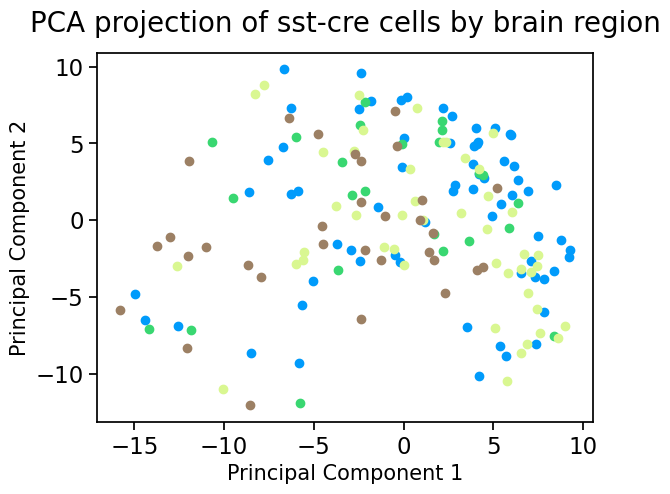

In [81]:
label2 = structure_ids_array
#Getting unique labels
structure_labels = ['VISp','VISl', 'VISal', 'VISam']
 
u_labels = np.unique(label2)
 
#plotting the results:
hues = sns.color_palette("Spectral")
 
for i in u_labels:
    plt.scatter(df_kmeans[label2 == i , 0] , df_kmeans[label2 == i , 1] , label = i, color = colors_structures[i-1])
#plt.legend(structure_labels,loc='center left', bbox_to_anchor=(1, 0.5))

plt.xlabel('Principal Component 1', fontsize = 15)
plt.ylabel('Principal Component 2', fontsize = 15)
plt.title('PCA projection of ' + end_folder + ' cells by brain region', fontsize = 20, pad = 15)

if save_plots==True:
    plt.savefig(genotype_image_path+'PCA_by_targetedstructure.svg', format = "svg")

plt.show()


In [82]:
cell_ticks = [0,len(curr_df.cell_specimen_id.unique())]
cell_ticks

[0, 169]

## Plot activity by cluster

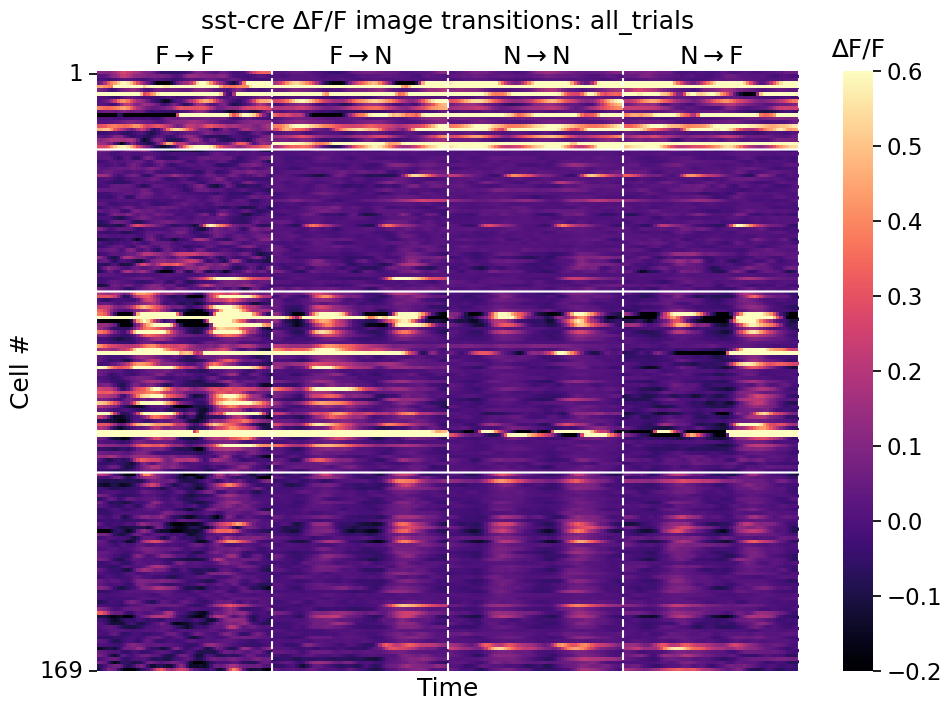

In [83]:
fig, axs = plt.subplots(sharey=True,
                        squeeze=False, #makes sure a 2D array of axs is always returned even if only 1 row/column
                        figsize = (10, 7), #have fig-size depend on number of companys/metrics
                        )
fig.tight_layout()

#dff_flat_list = []
plot_columns = ['dff_all']
cell_ticks = [1,len(curr_df.cell_specimen_id.unique())]
for n, dff_list in enumerate(plot_columns):
    dff_array = np.array(sorted_clustered_df[dff_list].tolist())
    
    dff_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)
    
    # Determine the positions where the kmeans_labels change
    label_changes = np.where(np.diff(sorted_clustered_df['kmeans_labels']))[0] + 1

    
    #name_list = [r'N$\rightarrow$N', r'N$\rightarrow$F', r'F$\rightarrow$F', r'F$\rightarrow$N']
    if n==2:
        sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0,n], vmin=dff_vmin, vmax=dff_vmax)
    else:
        sp = sns.heatmap(dff_flat,cmap='magma', 
                         #cbar=False, 
                         ax=axs[0,n], vmin=dff_vmin, vmax=dff_vmax)
    
    # sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)

    cbar = plt.gcf().axes[-1] 
    cbar.set_title('∆F/F', pad=10)  # Horizontal label
    #cbar.ax.yaxis.set_label_position('left')  # Position the label above the colorbar
    
    line_offset = 0
    for i in range(4):
        timepts = dff_array.shape[-1]
        sp.axvline(timepts*(i+1), color='w', linestyle='--')
        sp.text(timepts*(i+1)-timepts/2, -2, name_list[i], horizontalalignment='center')
        

        #temp_df = vip_stacked_dict[mouse_id_list[i]]
        #cell_ct = len(temp_df.cell_specimen_id.unique())
        #sp.axhline(cell_ct + line_offset, color='w', linewidth=1)
        #line_offset = line_offset + cell_ct
        
        for change in label_changes:
            sp.axhline(y=change, color='white', linewidth=1)

    # line_offset = 0
    # for mouse_id in mouse_id_list:
    #     temp_df = vip_stacked_dict[mouse_id]
    #     cell_ct = len(temp_df.cell_specimen_id.unique())
    #     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
    #     line_offset = line_offset + cell_ct

    
    sp.set_title(f'{end_folder} ∆F/F image transitions: ' + groups_types_list[n], pad=30)
    sp.set_ylabel('Cell #');
    sp.set_yticks(ticks=cell_ticks, labels=cell_ticks);
    sp.set_xlabel('Time');
    sp.set_xticks(ticks=[], labels = [])
    
   # dff_flat_list += [dff_flat]

# Save as SVG

if save_plots==True:
    plt.savefig(genotype_image_path+'sorted_dff_heatmap.svg', format = "svg")
plt.show()

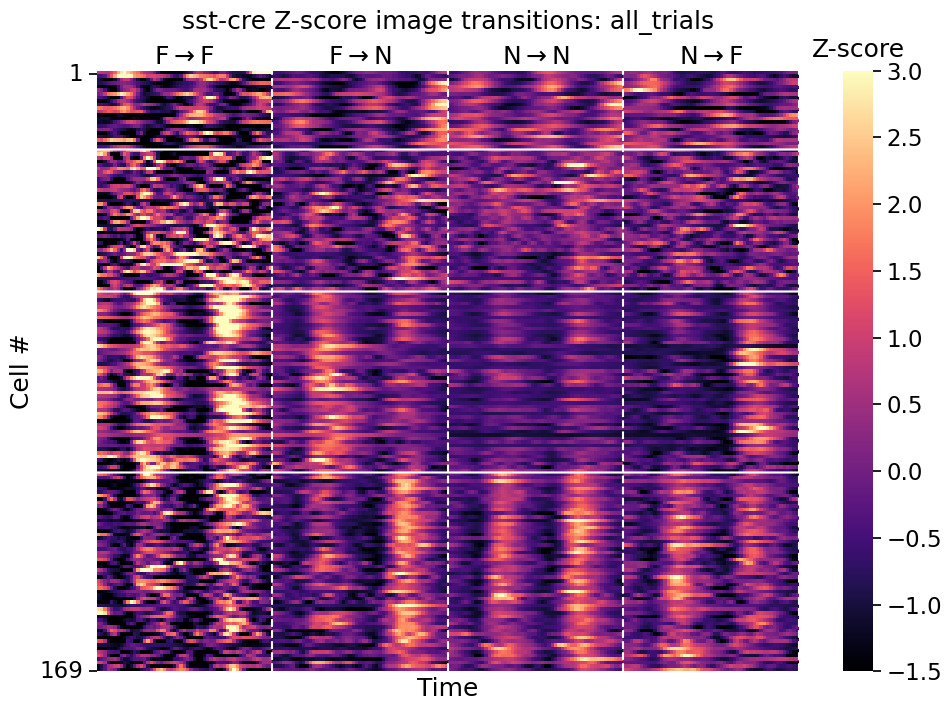

In [84]:
fig, axs = plt.subplots(sharey=True,
                        squeeze=False, #makes sure a 2D array of axs is always returned even if only 1 row/column
                        figsize = (10, 7), #have fig-size depend on number of companys/metrics
                        )
fig.tight_layout()

#dff_flat_list = []
plot_columns = ['z_all']

for n, dff_list in enumerate(plot_columns):
    dff_flat = np.array(sorted_clustered_df[dff_list].tolist())
    
    #dff_flat = dff_array.reshape(len(curr_df.cell_specimen_id.unique()),-1)
    
    # Determine the positions where the kmeans_labels change
    label_changes = np.where(np.diff(sorted_clustered_df['kmeans_labels']))[0] + 1

    
    #name_list = [r'N$\rightarrow$N', r'N$\rightarrow$F', r'F$\rightarrow$F', r'F$\rightarrow$N']
    if n==2:
        sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0,n], vmin=z_vmin, vmax=z_vmax)
    else:
        sp = sns.heatmap(dff_flat,cmap='magma', 
                         #cbar=False, 
                         ax=axs[0,n], vmin=z_vmin, vmax=z_vmax)
    
    # sp = sns.heatmap(dff_flat,cmap='magma', ax=axs[0][n], vmin=-0.15, vmax=0.8)

    cbar = plt.gcf().axes[-1] 
    cbar.set_title('Z-score', pad=10)  # Horizontal label
    #cbar.ax.yaxis.set_label_position('left')  # Position the label above the colorbar
    
    line_offset = 0
    for i in range(4):
        timepts = dff_array.shape[-1]
        sp.axvline(timepts*(i+1), color='w', linestyle='--')
        sp.text(timepts*(i+1)-timepts/2, -2, name_list[i], horizontalalignment='center')
        

        #temp_df = vip_stacked_dict[mouse_id_list[i]]
        #cell_ct = len(temp_df.cell_specimen_id.unique())
        #sp.axhline(cell_ct + line_offset, color='w', linewidth=1)
        #line_offset = line_offset + cell_ct
        
        for change in label_changes:
            sp.axhline(y=change, color='white', linewidth=1)

    # line_offset = 0
    # for mouse_id in mouse_id_list:
    #     temp_df = vip_stacked_dict[mouse_id]
    #     cell_ct = len(temp_df.cell_specimen_id.unique())
    #     plt.axhline(cell_ct + line_offset, color='w', linestyle='--', linewidth=1)
    #     line_offset = line_offset + cell_ct

    
    sp.set_title(f'{end_folder} Z-score image transitions: ' + groups_types_list[n], pad=30)
    sp.set_ylabel('Cell #');
    sp.set_yticks(ticks=cell_ticks, labels=cell_ticks);
    sp.set_xlabel('Time');
    sp.set_xticks(ticks=[], labels = [])
    
 #   dff_flat_list += [dff_flat]

# Save as SVG

if save_plots==True:
    plt.savefig(genotype_image_path+'sorted_zscore_heatmap.svg', format = "svg")
plt.show()

## Plot cell distribution across clusters

In [85]:

sorted_clustered_df.groupby(['kmeans_labels', 'cell_specimen_id']).count().reset_index().groupby(['kmeans_labels']).count()[['cell_specimen_id']]


cell_specimen_id
kmeans_labels                  
0                            22
1                            40
2                            51
3                            56

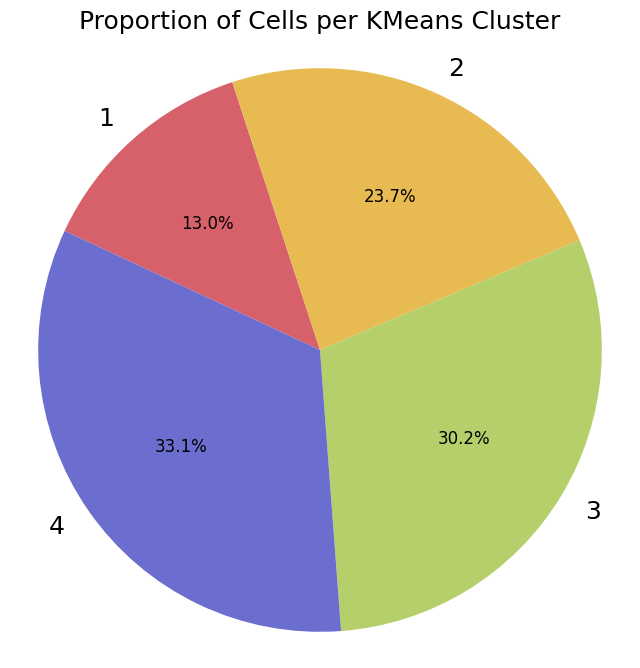

In [86]:
# Calculate the number of cells per KMeans cluster
cell_counts = sorted_clustered_df.groupby(['kmeans_labels', 'cell_specimen_id']).count().reset_index().groupby(['kmeans_labels']).count()[['cell_specimen_id']]

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(cell_counts['cell_specimen_id'], labels=cell_counts.index+1, autopct='%1.1f%%', startangle=155, colors=colors_clusters,
                                  textprops={'fontsize': 18, 'color': 'black'},  # Font size and color for the labels
                                  counterclock=False
                                 )

# Customize the font size and color of the percentages
for autotext in autotexts:
    autotext.set_fontsize(12)  # Set the font size of the percentages
    autotext.set_color('black')  # Set the color of the percentages

# Add a title
ax.set_title('Proportion of Cells per KMeans Cluster', pad=10)

# Equal aspect ratio ensures that the pie is drawn as a circle.
ax.axis('equal')  

# Display the plot
plt.show()

In [87]:
# structure_mapping = {
#     'VISp': 1,
#     'VISl': 2,
#     'VISal': 3,
#     'VISam': 4
# }

In [88]:
visp_df = sorted_clustered_df[(sorted_clustered_df.targeted_structure_id==1)]

In [89]:
visl_df = sorted_clustered_df[(sorted_clustered_df.targeted_structure_id==2)]

In [90]:
visal_df = sorted_clustered_df[(sorted_clustered_df.targeted_structure_id==3)]

In [91]:
visam_df = sorted_clustered_df[(sorted_clustered_df.targeted_structure_id==4)]

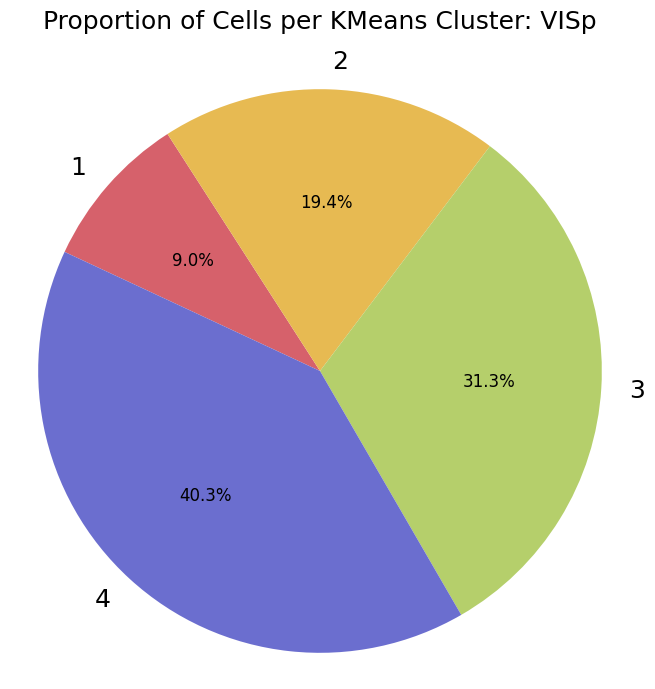

In [92]:
# Calculate the number of cells per KMeans cluster
visp_counts = visp_df.groupby(['kmeans_labels', 'cell_specimen_id']).count().reset_index().groupby(['kmeans_labels']).count()[['cell_specimen_id']]

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(visp_counts['cell_specimen_id'], labels=visp_counts.index+1, autopct='%1.1f%%', startangle=155, colors=colors_clusters,
                                  textprops={'fontsize': 18, 'color': 'black'},  # Font size and color for the labels
                                  counterclock=False
                                 )

# Customize the font size and color of the percentages
for autotext in autotexts:
    autotext.set_fontsize(12)  # Set the font size of the percentages
    autotext.set_color('black')  # Set the color of the percentages

# Add a title
ax.set_title('Proportion of Cells per KMeans Cluster: VISp', pad=25)

# Equal aspect ratio ensures that the pie is drawn as a circle.
ax.axis('equal')  

# Display the plot
plt.show()

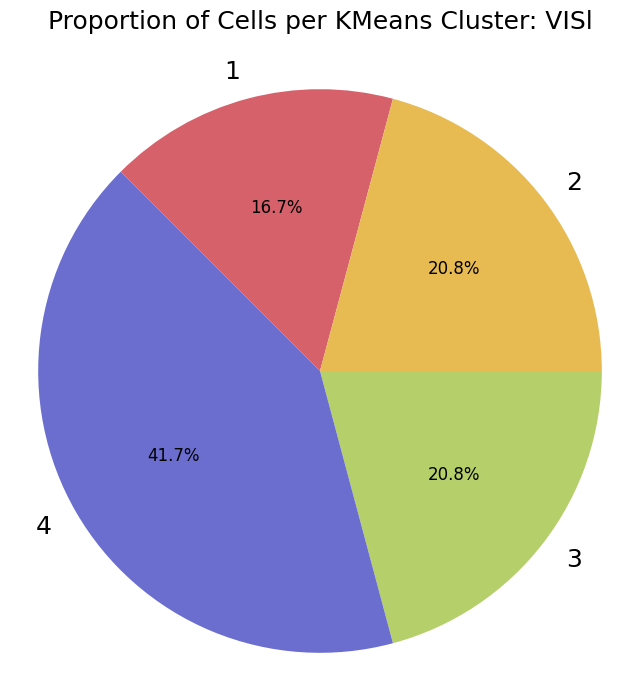

In [93]:
# Calculate the number of cells per KMeans cluster
visl_counts = visl_df.groupby(['kmeans_labels', 'cell_specimen_id']).count().reset_index().groupby(['kmeans_labels']).count()[['cell_specimen_id']]

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(visl_counts['cell_specimen_id'], labels=visl_counts.index+1, autopct='%1.1f%%', startangle=135, colors=colors_clusters,
                                  textprops={'fontsize': 18, 'color': 'black'},  # Font size and color for the labels
                                  counterclock=False
                                 )

# Customize the font size and color of the percentages
for autotext in autotexts:
    autotext.set_fontsize(12)  # Set the font size of the percentages
    autotext.set_color('black')  # Set the color of the percentages

# Add a title
ax.set_title('Proportion of Cells per KMeans Cluster: VISl', pad=25)

# Equal aspect ratio ensures that the pie is drawn as a circle.
ax.axis('equal')  

# Display the plot
plt.show()

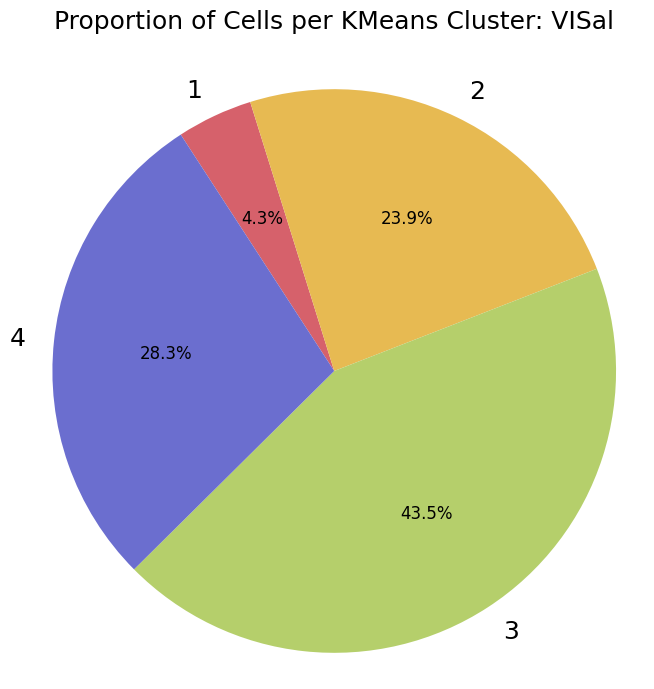

In [94]:
# Calculate the number of cells per KMeans cluster
visal_counts = visal_df.groupby(['kmeans_labels', 'cell_specimen_id']).count().reset_index().groupby(['kmeans_labels']).count()[['cell_specimen_id']]

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(visal_counts['cell_specimen_id'], labels=visal_counts.index+1, autopct='%1.1f%%', startangle=123, colors=colors_clusters,
                                  textprops={'fontsize': 18, 'color': 'black'},  # Font size and color for the labels
                                  counterclock=False
                                 )

# Customize the font size and color of the percentages
for autotext in autotexts:
    autotext.set_fontsize(12)  # Set the font size of the percentages
    autotext.set_color('black')  # Set the color of the percentages

# Add a title
ax.set_title('Proportion of Cells per KMeans Cluster: VISal', pad=25)

# Equal aspect ratio ensures that the pie is drawn as a circle.
ax.axis('equal')  

# Display the plot
plt.show()

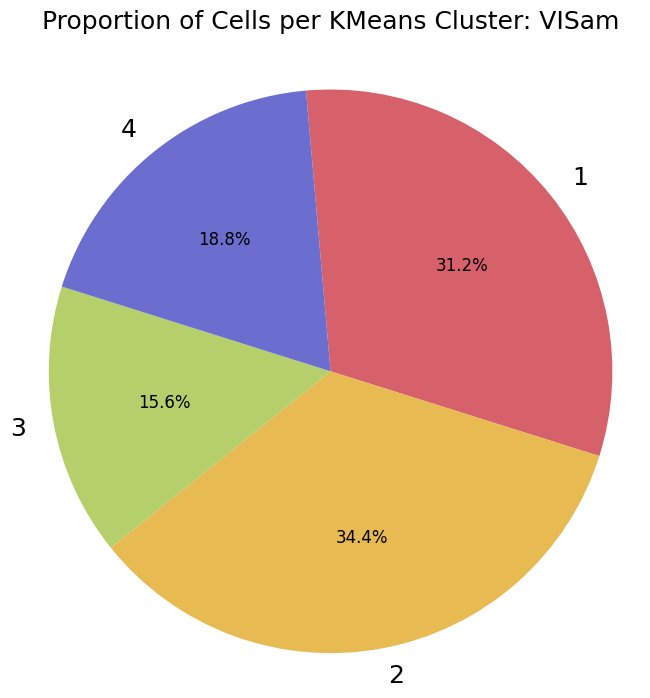

In [95]:
# Calculate the number of cells per KMeans cluster
visam_counts = visam_df.groupby(['kmeans_labels', 'cell_specimen_id']).count().reset_index().groupby(['kmeans_labels']).count()[['cell_specimen_id']]

# Create the pie chart
fig, ax = plt.subplots(figsize=(8, 8))
wedges, texts, autotexts = ax.pie(visam_counts['cell_specimen_id'], labels=visam_counts.index+1, autopct='%1.1f%%', startangle=95, colors=colors_clusters,
                                  textprops={'fontsize': 18, 'color': 'black'},  # Font size and color for the labels
                                  counterclock=False
                                 )

# Customize the font size and color of the percentages
for autotext in autotexts:
    autotext.set_fontsize(12)  # Set the font size of the percentages
    autotext.set_color('black')  # Set the color of the percentages

# Add a title
ax.set_title('Proportion of Cells per KMeans Cluster: VISam', pad=25)

# Equal aspect ratio ensures that the pie is drawn as a circle.
ax.axis('equal')  

# Display the plot
plt.show()

## Plot distribution of cells in clusters by brain region

In [96]:
sorted_clustered_df.groupby(['kmeans_labels', 'targeted_structure_id', 'cell_specimen_id']).count().reset_index().groupby(['kmeans_labels', 'targeted_structure_id']).count()[['cell_specimen_id']]


cell_specimen_id
kmeans_labels targeted_structure_id                  
0             1                                     6
              2                                     4
              3                                     2
              4                                    10
1             1                                    13
              2                                     5
              3                                    11
              4                                    11
2             1                                    21
              2                                     5
              3                                    20
              4                                     5
3             1                                    27
              2                                    10
              3                                    13
              4                                     6

In [97]:
xlabels = np.arange(1,num_clusters+1)


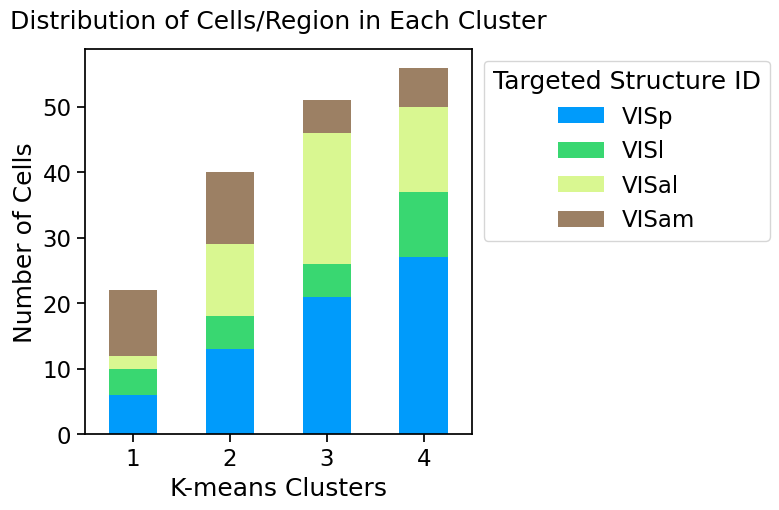

In [98]:
structure_labels = ['VISp','VISl', 'VISal', 'VISam']
ticks = np.arange(0, num_clusters)
# Step 1: Group and Aggregate
grouped = sorted_clustered_df.groupby(['kmeans_labels', 'targeted_structure_id']).count().reset_index()

# Step 2: Pivot the DataFrame
pivot_df = grouped.pivot(index='kmeans_labels', columns='targeted_structure_id', values='cell_specimen_id').fillna(0)

# Step 3: Plot the Stacked Bar Chart
pivot_df.plot(kind='bar', stacked=True, figsize=(5, 5), color=colors_structures)

plt.xticks(ticks=ticks, labels=[str(i+1) for i in ticks], rotation=0)

# Add labels and title
plt.xlabel('K-means Clusters')
plt.ylabel('Number of Cells')
plt.title('Distribution of Cells/Region in Each Cluster', pad=15)
plt.legend(structure_labels, title='Targeted Structure ID',bbox_to_anchor=(1, 1), loc='upper left')

# Display the plot

if save_plots==True:
    plt.savefig(genotype_image_path+'cluster_celldistribution_barchart.svg', format = "svg")
plt.show()

/tmp/ipykernel_21668/2065024896.py:18: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend().set_visible(False)


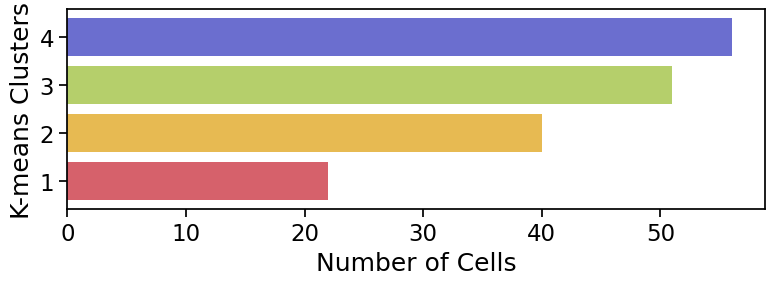

In [99]:
# Step 1: Group and Aggregate by the number of cells in each cluster
grouped = sorted_clustered_df.groupby(['kmeans_labels']).size().reset_index(name='cell_count')

# Step 2: Plot a Bar Chart for each cluster colored by its cluster color
fig, ax = plt.subplots(figsize=(9, 2.6))
ax.barh(grouped['kmeans_labels'], grouped['cell_count'], color=colors_clusters)

# Customize the x-axis ticks and labels
ticks = np.arange(0, num_clusters)
plt.yticks(ticks=ticks, labels=[str(i+1) for i in ticks], rotation=0)

# Add labels and title
plt.ylabel('K-means Clusters')
plt.xlabel('Number of Cells')
#plt.title('Distribution of Cells in Each Cluster', pad=20)

# Optional: Remove legend if no longer needed
plt.legend().set_visible(False)

# Adjust layout and save the plot
if save_plots==True:
    plt.savefig(genotype_image_path+'cluster_celldistribution_barchart_single_color', format="svg")
plt.show()

In [100]:
# #### structure_labels = ['VISp','VISl', 'VISal', 'VISam']
# ticks = np.arange(0, num_clusters)
# # Step 1: Group and Aggregate
# grouped = sorted_clustered_df.groupby(['kmeans_labels']).count().reset_index()

# # Step 2: Pivot the DataFrame
# pivot_df = grouped.pivot(index='kmeans_labels', columns='targeted_structure_id', values='cell_specimen_id').fillna(0)

# # Step 3: Plot the Stacked Bar Chart
# pivot_df.plot(kind='bar', stacked=True, figsize=(7, 7), color=colors_clusters[1])

# plt.xticks(ticks=ticks, labels=[str(i+1) for i in ticks], rotation=0)

# # Add labels and title
# plt.xlabel('K-means Clusters')
# plt.ylabel('Number of Cells')
# plt.title('Distribution of Cells in Each Cluster')
# #plt.legend(structure_labels, title='Targeted Structure ID', bbox_to_anchor=(1.05, 1), loc='upper right')
# plt.legend().set_visible(False)
# plt.tight_layout()

# # Display the plot
# if save_plots==True:
#     plt.savefig(genotype_image_path+'cluster_celldistribution_barchart', format = "svg")
# plt.show()

In [101]:
region_totals = sorted_clustered_df.groupby('targeted_structure_id').count()['cell_specimen_id']
region_totals

targeted_structure_id
1    67
2    24
3    46
4    32
Name: cell_specimen_id, dtype: int64

In [102]:
sorted_clustered_df.columns

Index(['targeted_structure_id', 'cell_specimen_id', 'df_kmeans', 'z_all',
       'z_hit', 'z_miss', 'kmeans_labels_unsorted', 'dff_all', 'dff_hit',
       'dff_miss', 'dff_mean_nn', 'dff_mean_nf', 'dff_mean_ff', 'dff_mean_fn',
       'kmeans_labels'],
      dtype='object')

In [103]:


cluster_totals = sorted_clustered_df.groupby(['kmeans_labels', 'targeted_structure_id', 'cell_specimen_id']).count().reset_index().groupby(['kmeans_labels', 'targeted_structure_id']).count()[['cell_specimen_id']]


In [104]:
# Assuming sorted_clustered_df is your DataFrame

# Step 1: Calculate total counts per targeted_structure_id
total_counts_per_structure = sorted_clustered_df.groupby('targeted_structure_id')['cell_specimen_id'].count().reset_index()
total_counts_per_structure.rename(columns={'cell_specimen_id': 'total_count'}, inplace=True)

# Step 2: Calculate counts per kmeans cluster and targeted_structure_id
cluster_counts = sorted_clustered_df.groupby(['kmeans_labels', 'targeted_structure_id'])['cell_specimen_id'].count().reset_index()
cluster_counts.rename(columns={'cell_specimen_id': 'cluster_count'}, inplace=True)

# Merge to get total counts with cluster counts
merged_counts = pd.merge(cluster_counts, total_counts_per_structure, on='targeted_structure_id')

# Step 3: Normalize the counts
merged_counts['normalized_count'] = merged_counts['cluster_count'] / merged_counts['total_count']

# Optionally, reset index if needed
normalized_counts = merged_counts[['kmeans_labels', 'targeted_structure_id', 'normalized_count']]

print(normalized_counts)

    kmeans_labels  targeted_structure_id  normalized_count
0               0                      1          0.089552
1               1                      1          0.194030
2               2                      1          0.313433
3               3                      1          0.402985
4               0                      2          0.166667
5               1                      2          0.208333
6               2                      2          0.208333
7               3                      2          0.416667
8               0                      3          0.043478
9               1                      3          0.239130
10              2                      3          0.434783
11              3                      3          0.282609
12              0                      4          0.312500
13              1                      4          0.343750
14              2                      4          0.156250
15              3                      4          0.1875

In [105]:
pivot_df

targeted_structure_id   1   2   3   4
kmeans_labels                        
0                       6   4   2  10
1                      13   5  11  11
2                      21   5  20   5
3                      27  10  13   6

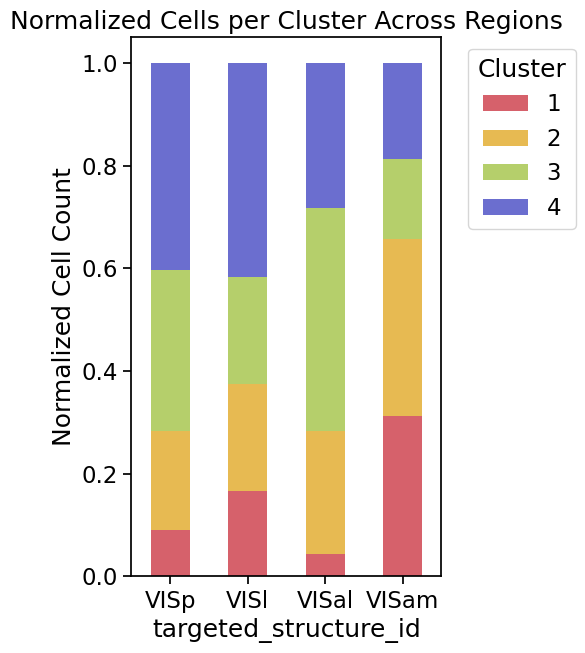

In [106]:
# Step 1: Pivot the DataFrame for plotting
pivot_df = normalized_counts.pivot(index='targeted_structure_id', columns='kmeans_labels', values='normalized_count')

ticks = np.arange(0, 4)
clus_range = np.arange(0,num_clusters)

# Step 2: Plot the data as a stacked bar chart
ax = pivot_df.plot(kind='bar', stacked=True, figsize=(4, 7), color=colors_clusters)

# Set labels and title
#plt.xlabel('Targeted Region')
plt.ylabel('Normalized Cell Count')
plt.title('Normalized Cells per Cluster Across Regions')
plt.legend([str(i+1) for i in clus_range], title='Cluster', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(ticks=ticks, labels=structure_labels, rotation=0)

if save_plots==True:
    plt.savefig(genotype_image_path+'cluster_normalizedcelldistribution_barchart.svg', format = "svg")

# Show the plot
plt.show()

# Plot Cluster Averaged Traces

## Plot cluster traces - all trials

## Set axis limits


In [107]:
if end_folder == 'vip-cre':
    dff_min = -0.05
    dff_max = 0.25

    z_min = -1.5
    z_max = 2.5
    
elif end_folder == 'sst-cre':
    dff_min = -0.5
    dff_max = 1.7

    z_min = -1.5
    z_max = 3
    
elif end_folder == 'slc17a7-cre':
    dff_min = -0.05
    dff_max = 0.25

    z_min = -1.5
    z_max = 2.5

### Plot all clusters ∆F/F

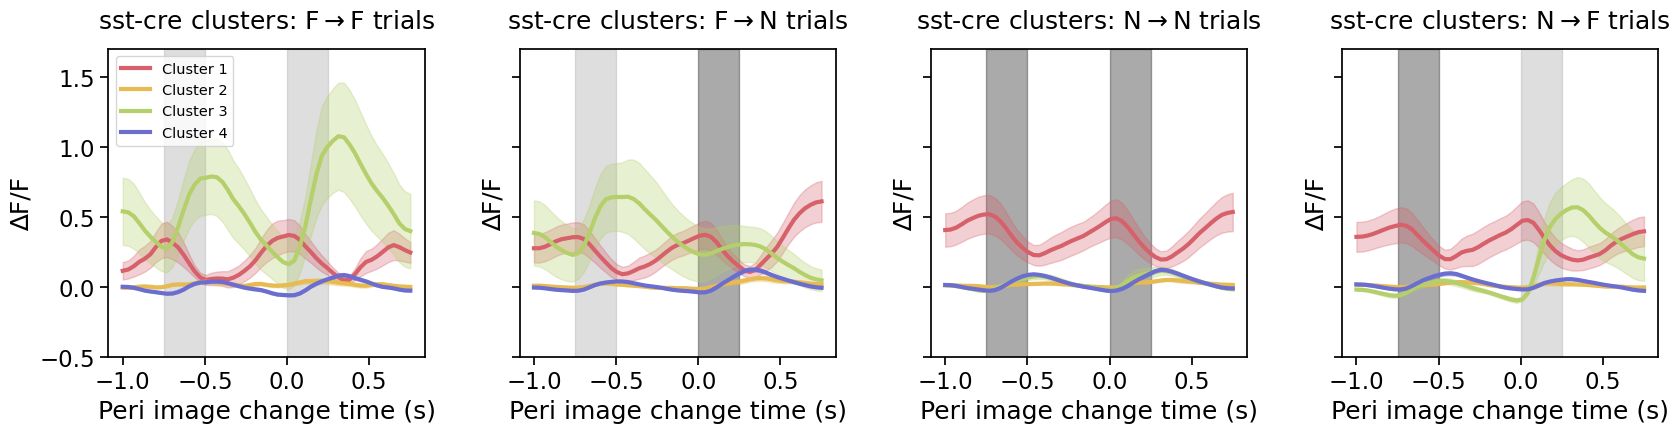

In [108]:
# Plot events for all clusters: ∆F/F
fig, ax = plt.subplots(1,4, figsize=(20, 4), sharey=True)
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.5, wspace=0.3)  # Increase spacing between plots
#fig.tight_layout()


hues = colors_clusters
novel_hues = sns.color_palette("PRGn")
familiar_hues = sns.color_palette("Paired")
mixed_hues = sns.color_palette("Paired")

c = sns.color_palette('Grays')
palette = [c[2], c[5]]
color_dict = {'F':palette[0], 'N':palette[1]}

mean_width = 3

# F-F
ax[0].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4) # familiar image
#ax[0].axvspan(-0.01, 0, color='red', alpha=0.7) # image change   
ax[0].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4) # novel image


ax[1].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4) # novel image
#ax[1].axvspan(-0.01, 0, color='red', alpha=0.7) # image change   
ax[1].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4) # novel image

ax[2].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4) # novel image
#ax[2].axvspan(-0.01, 0, color='blue', alpha=0.7) # image change   
ax[2].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4) # familiar image


ax[3].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4) # familiar image
#ax[3].axvspan(-0.01, 0, color='blue', alpha=0.7) # image change   
ax[3].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4) # familiar image



# Plot familiar to familiar transitions
for i,cluster_id in enumerate(sorted_clustered_df.kmeans_labels.unique()):
    # get the relevant data
    cell_df = sorted_clustered_df[sorted_clustered_df.kmeans_labels==cluster_id]
    
    dff_array = np.array(cell_df['dff_all'].tolist())
    
    dff_flat = dff_array.reshape(len(cell_df.cell_specimen_id.unique()),-1)
    #dff_array = np.array(cell_df.dff_all)
    
    
    # get the average dff trace
    mean_trace = np.mean(dff_flat, axis=0)
    sem_trace = np.std(dff_flat, axis=0) / np.sqrt(dff_flat.shape[0])
    
    # Create an x-axis for the data points (e.g., time or frame numbers)
    x_axis = np.arange(mean_trace.shape[0])

    
    # F:F
    ax[0].plot(np.linspace(-1, 0.75, 53), mean_trace[:53], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
    # Plot the SEM as a shaded area
    ax[0].fill_between(np.linspace(-1, 0.75, 53), mean_trace[:53] - sem_trace[:53], mean_trace[:53] + sem_trace[:53], color=hues[i], alpha=0.3)
    ax[0].legend(loc='upper left', fontsize='xx-small')
    
    # F:N  
    ax[1].plot(np.linspace(-1, 0.75, 53), mean_trace[53:106], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
    # Plot the SEM as a shaded area
    ax[1].fill_between(np.linspace(-1, 0.75, 53), mean_trace[53:106] - sem_trace[53:106], mean_trace[53:106] + sem_trace[53:106], color=hues[i], alpha=0.3)
    

    # N:N
    ax[2].plot(np.linspace(-1, 0.75, 53), mean_trace[106:159], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
    # Plot the SEM as a shaded area
    ax[2].fill_between(np.linspace(-1, 0.75, 53), mean_trace[106:159] - sem_trace[106:159], mean_trace[106:159] + sem_trace[106:159], color=hues[i], alpha=0.3)
    
    
    # N:F
    ax[3].plot(np.linspace(-1, 0.75, 53), mean_trace[159:], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
    # Plot the SEM as a shaded area
    ax[3].fill_between(np.linspace(-1, 0.75, 53), mean_trace[159:] - sem_trace[159:], mean_trace[159:] + sem_trace[159:], color=hues[i], alpha=0.3)
    

# Adjust the y-axis limits and add labels/titles to all subplots
for axis in ax.flatten():
    axis.set_ylim([dff_min, dff_max])
    axis.set_xlabel('Peri image change time (s)')
    axis.set_ylabel('∆F/F')
    #axis.legend(loc='lower left',bbox_to_anchor=(1, 0.6), fontsize=15)
        

# Set titles for each subplot
ax[0].set_title(end_folder + r' clusters: F$\rightarrow$F trials', pad=15)
ax[1].set_title(end_folder + r' clusters: F$\rightarrow$N trials', pad=15)
ax[2].set_title(end_folder + r' clusters: N$\rightarrow$N trials', pad=15)
ax[3].set_title(end_folder + r' clusters: N$\rightarrow$F trials', pad=15)
    

if save_plots==True:   
    plt.savefig(genotype_image_path+'cluster_dff_averages_trace.svg', format = "svg")
plt.show()


### Plot all clusters z-score

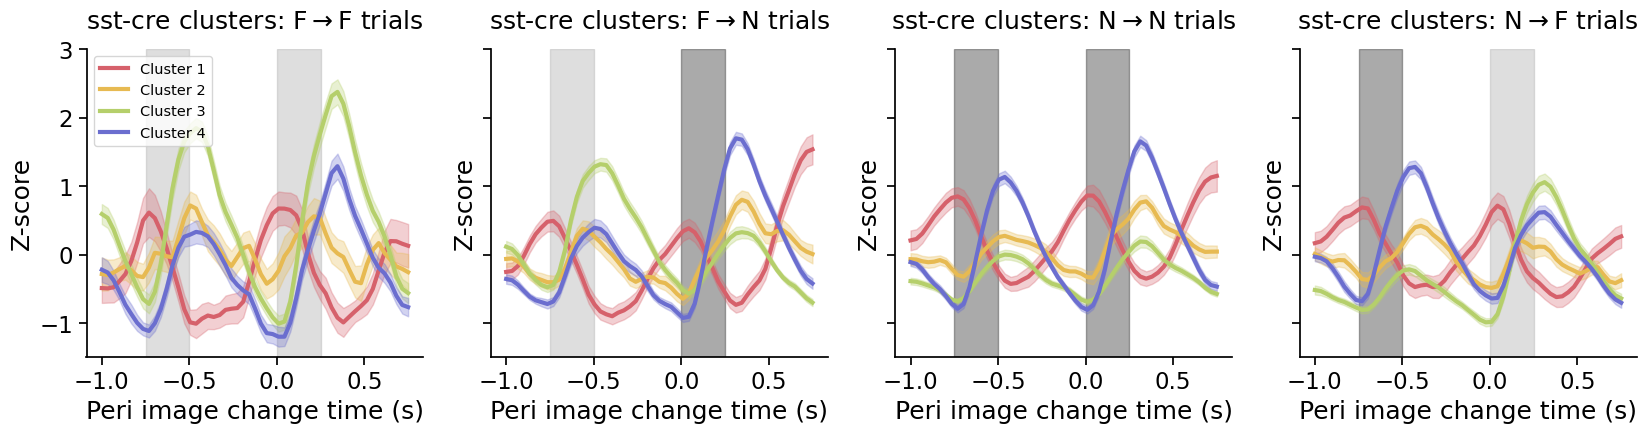

In [109]:
# Plot events for all clusters: Z-score
fig, ax = plt.subplots(1,4, figsize=(20, 4), sharey=True)
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.5, wspace=0.2)  # Increase spacing between plots
#fig.tight_layout()


hues = colors_clusters
novel_hues = sns.color_palette("PRGn")
familiar_hues = sns.color_palette("Paired")
mixed_hues = sns.color_palette("Paired")

c = sns.color_palette('Grays')
palette = [c[2], c[5]]
color_dict = {'F':palette[0], 'N':palette[1]}

mean_width = 3

# F-F
ax[0].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4) # familiar image
#ax[0].axvspan(-0.01, 0, color='red', alpha=0.7) # image change   
ax[0].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4) # novel image


ax[1].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4) # novel image
#ax[1].axvspan(-0.01, 0, color='red', alpha=0.7) # image change   
ax[1].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4) # novel image

ax[2].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4) # novel image
#ax[2].axvspan(-0.01, 0, color='blue', alpha=0.7) # image change   
ax[2].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4) # familiar image


ax[3].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4) # familiar image
#ax[3].axvspan(-0.01, 0, color='blue', alpha=0.7) # image change   
ax[3].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4) # familiar image



# Plot familiar to familiar transitions
for i,cluster_id in enumerate(sorted_clustered_df.kmeans_labels.unique()):
    # get the relevant data
    cell_df = sorted_clustered_df[sorted_clustered_df.kmeans_labels==cluster_id]
    
    dff_array = np.array(cell_df['z_all'].tolist())
    
    dff_flat = dff_array.reshape(len(cell_df.cell_specimen_id.unique()),-1)
    #dff_array = np.array(cell_df.dff_all)
    
    
    # get the average dff trace
    mean_trace = np.mean(dff_flat, axis=0)
    sem_trace = np.std(dff_flat, axis=0) / np.sqrt(dff_flat.shape[0])
    
    # Create an x-axis for the data points (e.g., time or frame numbers)
    x_axis = np.arange(mean_trace.shape[0])

    
    # F:F
    ax[0].plot(np.linspace(-1, 0.75, 53), mean_trace[:53], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
    # Plot the SEM as a shaded area
    ax[0].fill_between(np.linspace(-1, 0.75, 53), mean_trace[:53] - sem_trace[:53], mean_trace[:53] + sem_trace[:53], color=hues[i], alpha=0.3)
    ax[0].legend(loc='upper left', fontsize='xx-small')
    
    # F:N  
    ax[1].plot(np.linspace(-1, 0.75, 53), mean_trace[53:106], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
    # Plot the SEM as a shaded area
    ax[1].fill_between(np.linspace(-1, 0.75, 53), mean_trace[53:106] - sem_trace[53:106], mean_trace[53:106] + sem_trace[53:106], color=hues[i], alpha=0.3)
    

    # N:N
    ax[2].plot(np.linspace(-1, 0.75, 53), mean_trace[106:159], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
    # Plot the SEM as a shaded area
    ax[2].fill_between(np.linspace(-1, 0.75, 53), mean_trace[106:159] - sem_trace[106:159], mean_trace[106:159] + sem_trace[106:159], color=hues[i], alpha=0.3)
    
    
    # N:F
    ax[3].plot(np.linspace(-1, 0.75, 53), mean_trace[159:], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
    # Plot the SEM as a shaded area
    ax[3].fill_between(np.linspace(-1, 0.75, 53), mean_trace[159:] - sem_trace[159:], mean_trace[159:] + sem_trace[159:], color=hues[i], alpha=0.3)
    

# Adjust the y-axis limits and add labels/titles to all subplots
for axis in ax.flatten():
    axis.set_ylim([z_min, z_max])
    axis.set_xlabel('Peri image change time (s)')
    axis.set_ylabel('Z-score')
    axis.spines[['right', 'top']].set_visible(False)

    #axis.legend(loc='lower left',bbox_to_anchor=(1, 0.6), fontsize=15)
        

# Set titles for each subplot
ax[0].set_title(end_folder + r' clusters: F$\rightarrow$F trials', pad=15)
ax[1].set_title(end_folder + r' clusters: F$\rightarrow$N trials', pad=15)
ax[2].set_title(end_folder + r' clusters: N$\rightarrow$N trials', pad=15)
ax[3].set_title(end_folder + r' clusters: N$\rightarrow$F trials', pad=15)
    

if save_plots==True:    
    plt.savefig(genotype_image_path+'cluster_z_averages_trace.svg', format = "svg")
plt.show()


### Plot individual clusters z-score - all trials

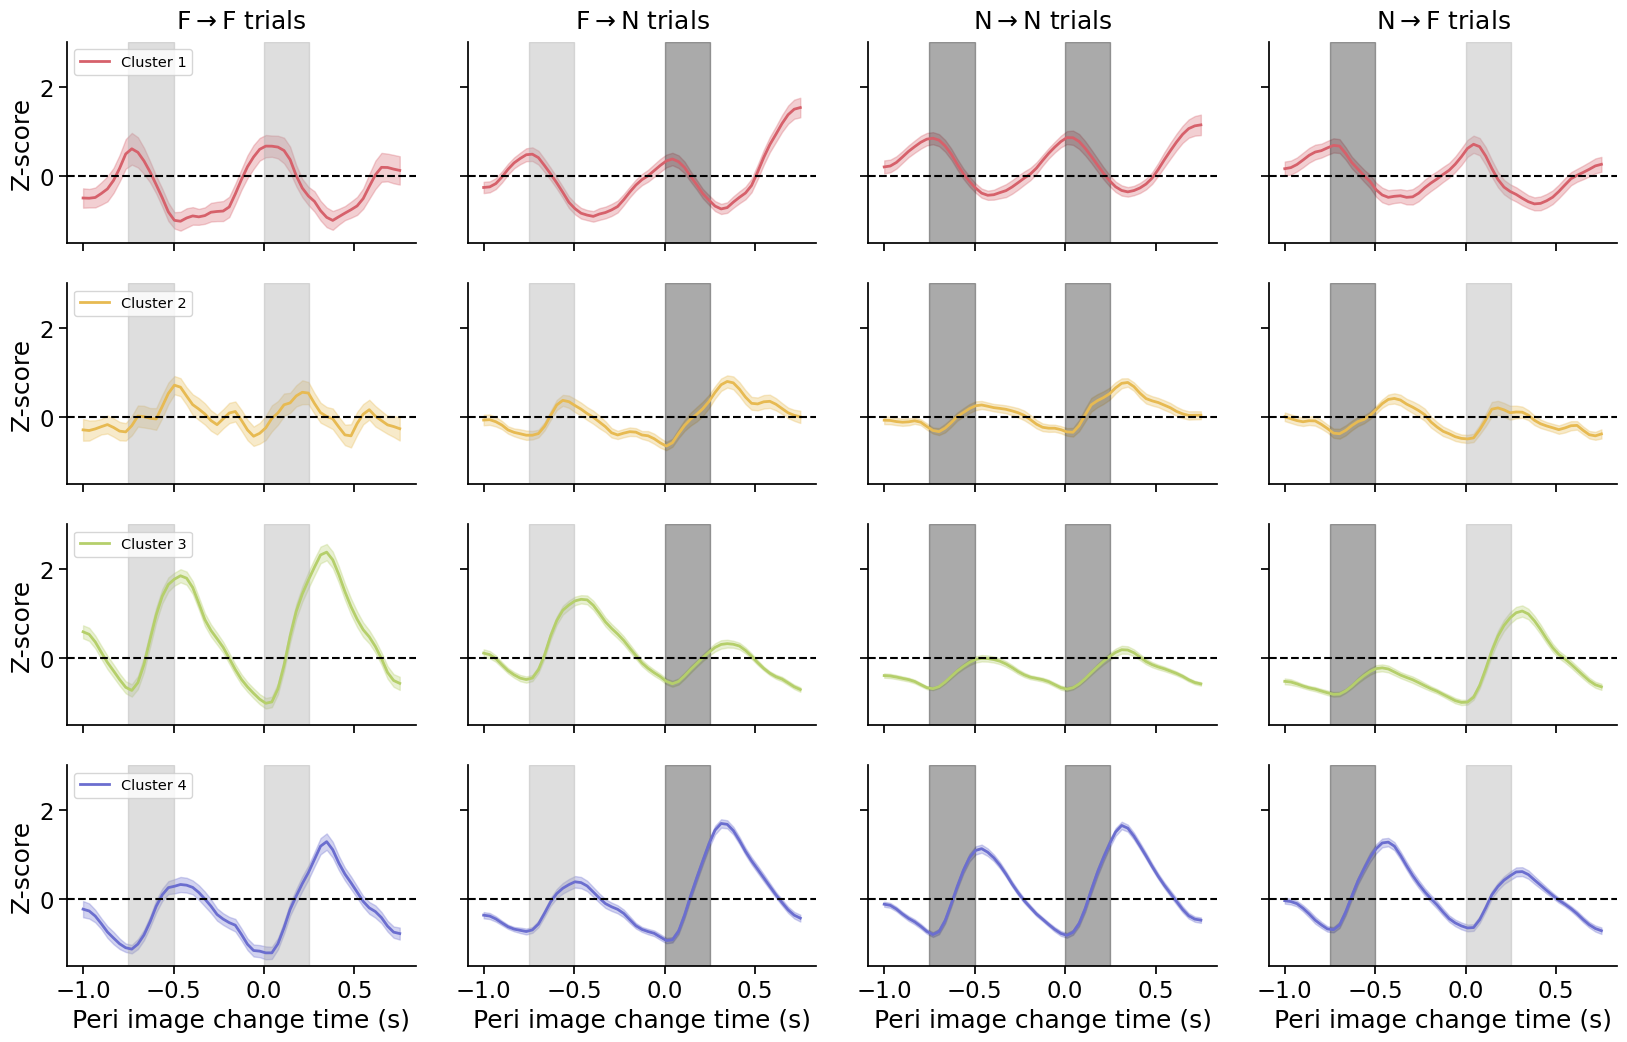

In [110]:
# Define the number of clusters
num_clusters = sorted_clustered_df.kmeans_labels.nunique()

# Plot events for all clusters: Z-score
fig, ax = plt.subplots(num_clusters, 4, figsize=(20, 3*num_clusters), sharey=True, sharex=True)
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.2, wspace=0.15)

hues = colors_clusters
c = sns.color_palette('Grays')
palette = [c[2], c[5]]
color_dict = {'F':palette[0], 'N':palette[1]}
mean_width = 2

# Loop over each cluster to create rows
for i, cluster_id in enumerate(sorted_clustered_df.kmeans_labels.unique()):
    # Get the relevant data
    cell_df = sorted_clustered_df[sorted_clustered_df.kmeans_labels == cluster_id]
    
    dff_array = np.array(cell_df['z_all'].tolist())
    dff_flat = dff_array.reshape(len(cell_df.cell_specimen_id.unique()), -1)
    
    # Get the average dff trace
    mean_trace = np.mean(dff_flat, axis=0)
    sem_trace = np.std(dff_flat, axis=0) / np.sqrt(dff_flat.shape[0])
    
    # F:F
    ax[i, 0].plot(np.linspace(-1, 0.75, 53), mean_trace[:53], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
    ax[i, 0].fill_between(np.linspace(-1, 0.75, 53), mean_trace[:53] - sem_trace[:53], mean_trace[:53] + sem_trace[:53], color=hues[i], alpha=0.3)
    ax[i, 0].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)
    ax[i, 0].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)
    ax[i, 0].legend(loc='upper left', fontsize='xx-small')
    
    # F:N
    ax[i, 1].plot(np.linspace(-1, 0.75, 53), mean_trace[53:106], color=hues[i], linewidth=mean_width)
    ax[i, 1].fill_between(np.linspace(-1, 0.75, 53), mean_trace[53:106] - sem_trace[53:106], mean_trace[53:106] + sem_trace[53:106], color=hues[i], alpha=0.3)
    ax[i, 1].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)
    ax[i, 1].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)
    
    # N:N
    ax[i, 2].plot(np.linspace(-1, 0.75, 53), mean_trace[106:159], color=hues[i], linewidth=mean_width)
    ax[i, 2].fill_between(np.linspace(-1, 0.75, 53), mean_trace[106:159] - sem_trace[106:159], mean_trace[106:159] + sem_trace[106:159], color=hues[i], alpha=0.3)
    ax[i, 2].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)
    ax[i, 2].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)
    
    # N:F
    ax[i, 3].plot(np.linspace(-1, 0.75, 53), mean_trace[159:], color=hues[i], linewidth=mean_width)
    ax[i, 3].fill_between(np.linspace(-1, 0.75, 53), mean_trace[159:] - sem_trace[159:], mean_trace[159:] + sem_trace[159:], color=hues[i], alpha=0.3)
    ax[i, 3].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)
    ax[i, 3].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)
    
    # Set titles for each cluster row
    if i == 0:
        ax[i, 0].set_title(r'F$\rightarrow$F trials', pad=10)
        ax[i, 1].set_title(r'F$\rightarrow$N trials', pad=10)
        ax[i, 2].set_title(r'N$\rightarrow$N trials', pad=10)
        ax[i, 3].set_title(r'N$\rightarrow$F trials', pad=10)
        
    if i == num_clusters-1:
        ax[i, 0].set_xlabel('Peri image change time (s)')
        ax[i, 1].set_xlabel('Peri image change time (s)')
        ax[i, 2].set_xlabel('Peri image change time (s)')
        ax[i, 3].set_xlabel('Peri image change time (s)')
        
        

# Adjust the y-axis limits and add labels to the first column of each row
for axis in ax.flatten():
    axis.set_ylim([z_min, z_max])
    axis.spines[['right', 'top']].set_visible(False)
    axis.axhline(0, color='black', linestyle='--')

    #

for i in range(num_clusters):
    ax[i, 0].set_ylabel('Z-score')

# Save and display the plot
if save_plots==True:
    plt.savefig(genotype_image_path+'individual_clusters_z_averages_trace.svg', format="svg")
plt.show()

In [111]:
colors_structures

[(0.0, 0.6058823529411764, 0.9823529411764705),
 (0.2235294117647059, 0.8447058823529412, 0.4447058823529412),
 (0.8509803921568627, 0.9701960784313726, 0.5701960784313725),
 (0.611764705882353, 0.5030588235294118, 0.39035294117647057)]

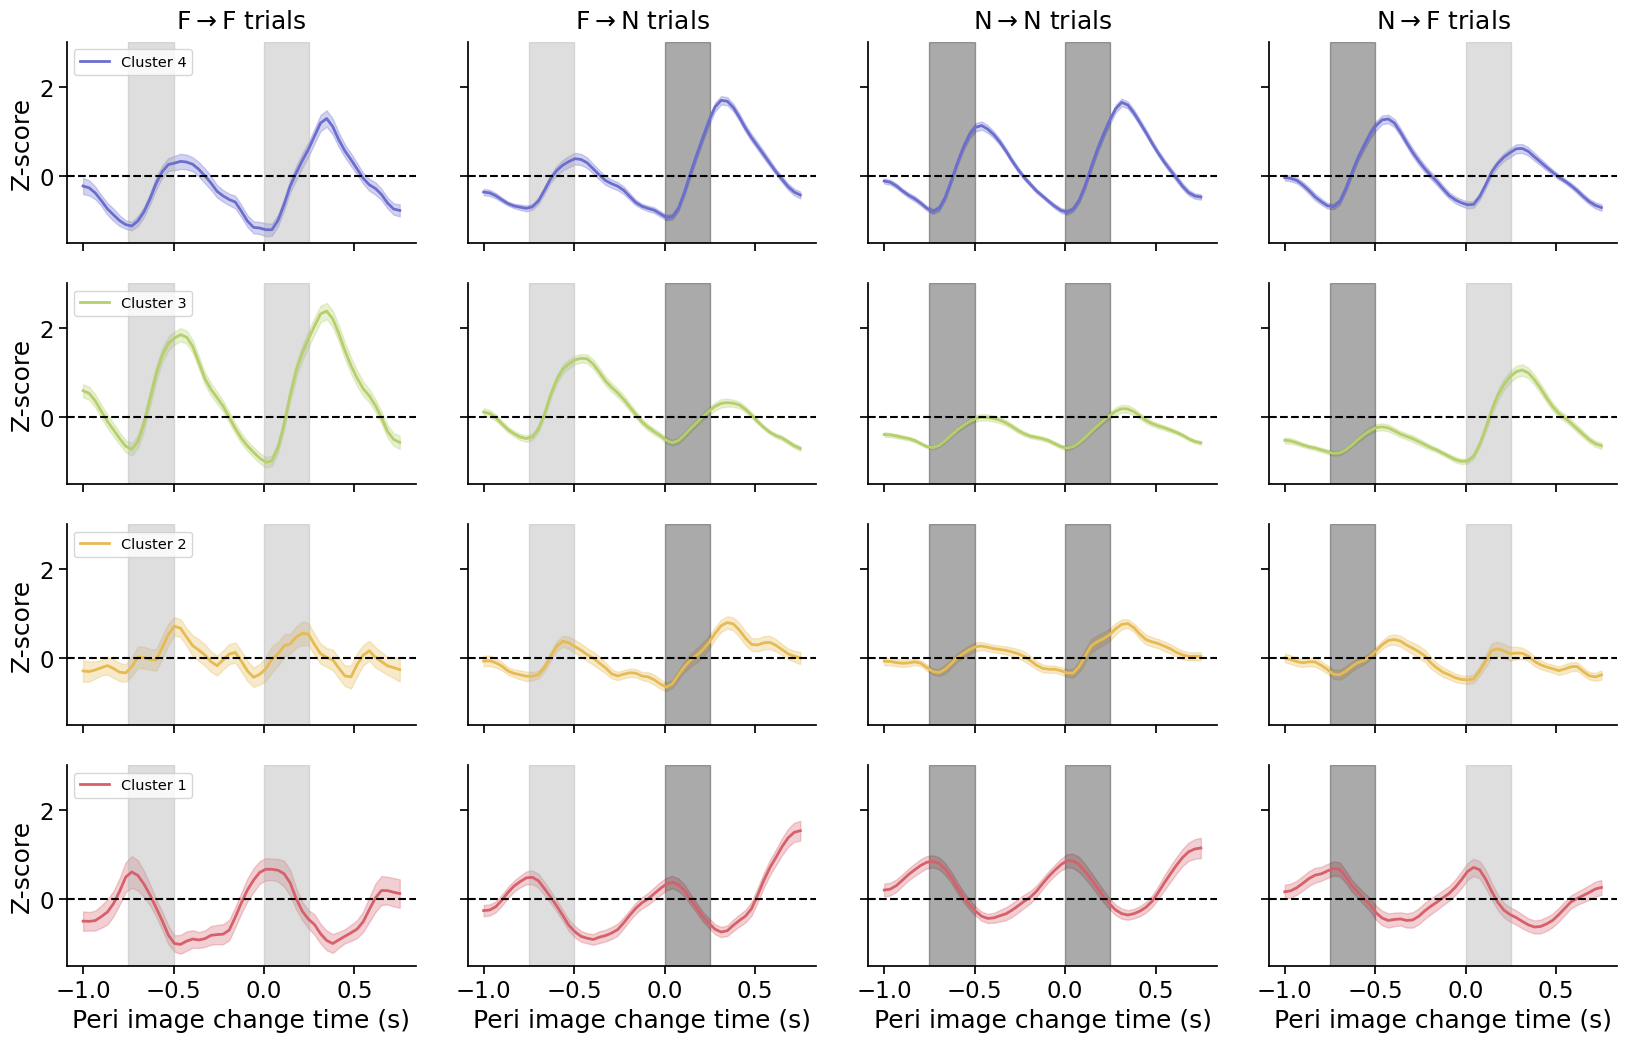

In [112]:
# Define the number of clusters
num_clusters = sorted_clustered_df.kmeans_labels.nunique()

# Plot events for all clusters: Z-score
fig, ax = plt.subplots(num_clusters, 4, figsize=(20, 3*num_clusters), sharey=True, sharex=True)
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.2, wspace=0.15)

hues = colors_clusters[::-1]
c = sns.color_palette('Grays')
palette = [c[2], c[5]]
color_dict = {'F':palette[0], 'N':palette[1]}
mean_width = 2



# Loop over each cluster to create rows
for i, cluster_id in enumerate(sorted_clustered_df.kmeans_labels.unique()[::-1]):
    # Get the relevant data
    cell_df = sorted_clustered_df[sorted_clustered_df.kmeans_labels == cluster_id]
    
    dff_array = np.array(cell_df['z_all'].tolist())
    dff_flat = dff_array.reshape(len(cell_df.cell_specimen_id.unique()), -1)
    
    # Get the average dff trace
    mean_trace = np.mean(dff_flat, axis=0)
    sem_trace = np.std(dff_flat, axis=0) / np.sqrt(dff_flat.shape[0])
    
    # F:F
    ax[i, 0].plot(np.linspace(-1, 0.75, 53), mean_trace[:53], color=hues[i], label='Cluster '+str(cluster_id+1), linewidth=mean_width)
    ax[i, 0].fill_between(np.linspace(-1, 0.75, 53), mean_trace[:53] - sem_trace[:53], mean_trace[:53] + sem_trace[:53], color=hues[i], alpha=0.3)
    ax[i, 0].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)
    ax[i, 0].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)
    ax[i, 0].legend(loc='upper left', fontsize='xx-small')
    
    # F:N
    ax[i, 1].plot(np.linspace(-1, 0.75, 53), mean_trace[53:106], color=hues[i], linewidth=mean_width)
    ax[i, 1].fill_between(np.linspace(-1, 0.75, 53), mean_trace[53:106] - sem_trace[53:106], mean_trace[53:106] + sem_trace[53:106], color=hues[i], alpha=0.3)
    ax[i, 1].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)
    ax[i, 1].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)
    
    # N:N
    ax[i, 2].plot(np.linspace(-1, 0.75, 53), mean_trace[106:159], color=hues[i], linewidth=mean_width)
    ax[i, 2].fill_between(np.linspace(-1, 0.75, 53), mean_trace[106:159] - sem_trace[106:159], mean_trace[106:159] + sem_trace[106:159], color=hues[i], alpha=0.3)
    ax[i, 2].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)
    ax[i, 2].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)
    
    # N:F
    ax[i, 3].plot(np.linspace(-1, 0.75, 53), mean_trace[159:], color=hues[i], linewidth=mean_width)
    ax[i, 3].fill_between(np.linspace(-1, 0.75, 53), mean_trace[159:] - sem_trace[159:], mean_trace[159:] + sem_trace[159:], color=hues[i], alpha=0.3)
    ax[i, 3].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)
    ax[i, 3].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)
    
    # Set titles for each cluster row
    if i == 0:
        ax[i, 0].set_title(r'F$\rightarrow$F trials', pad=10)
        ax[i, 1].set_title(r'F$\rightarrow$N trials', pad=10)
        ax[i, 2].set_title(r'N$\rightarrow$N trials', pad=10)
        ax[i, 3].set_title(r'N$\rightarrow$F trials', pad=10)
        
    if i == num_clusters-1:
        ax[i, 0].set_xlabel('Peri image change time (s)')
        ax[i, 1].set_xlabel('Peri image change time (s)')
        ax[i, 2].set_xlabel('Peri image change time (s)')
        ax[i, 3].set_xlabel('Peri image change time (s)')
        
        

# Adjust the y-axis limits and add labels to the first column of each row
for axis in ax.flatten():
    axis.set_ylim([z_min, z_max])
    axis.spines[['right', 'top']].set_visible(False)
    axis.axhline(0, color='black', linestyle='--')

    #

for i in range(num_clusters):
    ax[i, 0].set_ylabel('Z-score')

# Save and display the plot
if save_plots==True:
    plt.savefig(genotype_image_path+'individual_clusters_z_averages_trace.svg', format="svg")
plt.show()

## Plot cluster traces - hit vs miss trials

### Plot all clusters hit vs miss: z-score

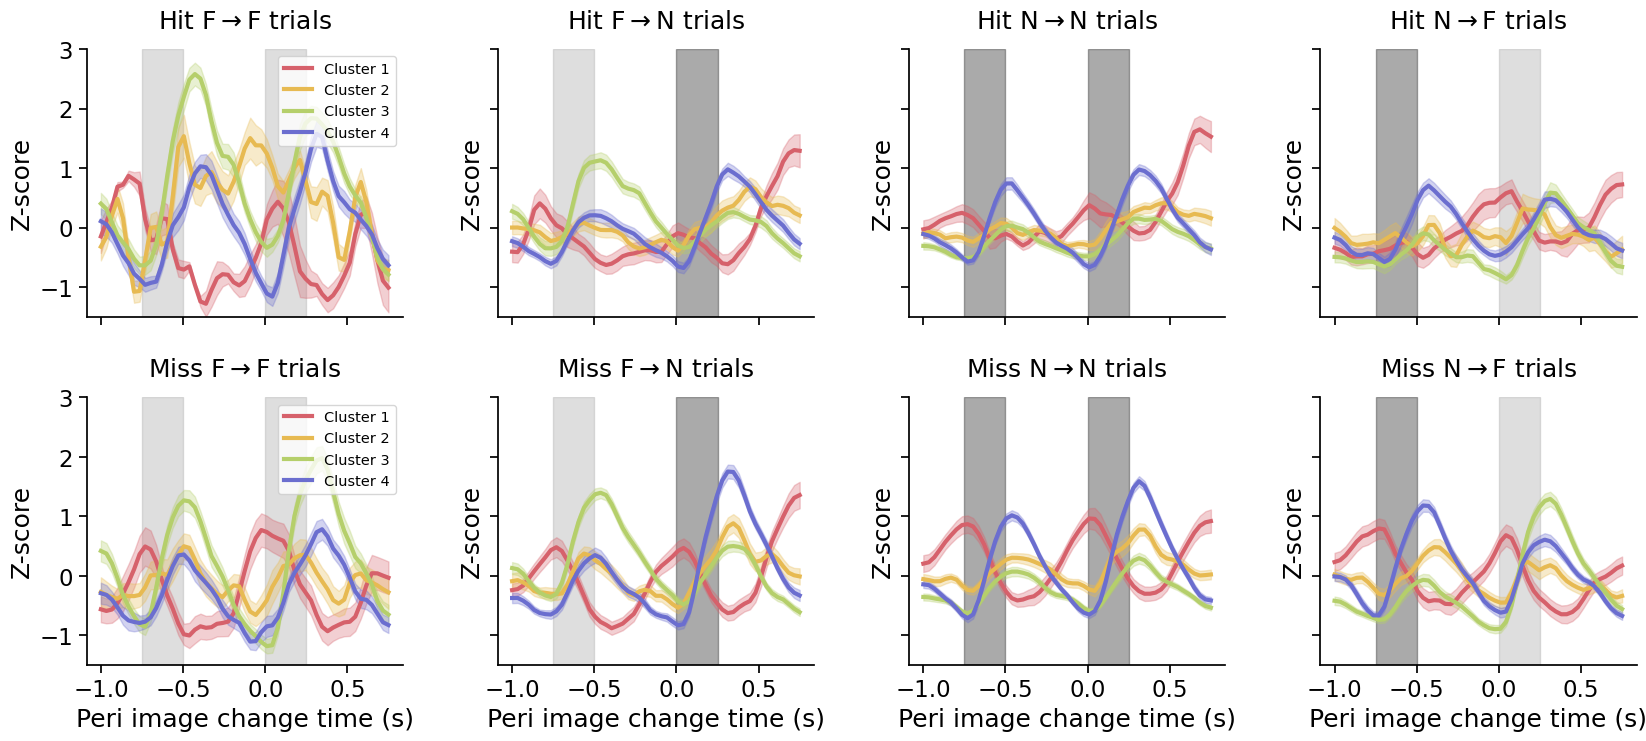

In [113]:
# Define the number of clusters
num_clusters = sorted_clustered_df.kmeans_labels.nunique()

# Create 2x4 subplots: top row for hits, bottom row for misses
fig, ax = plt.subplots(2, 4, figsize=(20, 8), sharey=True, sharex=True)
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.3, wspace=0.3)

hues = colors_clusters
novel_hues = sns.color_palette("PRGn")
familiar_hues = sns.color_palette("Paired")
mixed_hues = sns.color_palette("Paired")

c = sns.color_palette('Grays')
palette = [c[2], c[5]]
color_dict = {'F': palette[0], 'N': palette[1]}

mean_width = 3

# Plot the image change spans only once for all subplots
for j in range(2):
    ax[j, 0].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)  # F->F trial span
    ax[j, 0].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)

    ax[j, 1].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)  # F->N trial span
    ax[j, 1].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)

    ax[j, 2].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)  # N->N trial span
    ax[j, 2].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)

    ax[j, 3].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)  # N->F trial span
    ax[j, 3].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)

# Loop for both hit (top row) and miss (bottom row) trials
for j, trial_type in enumerate(['z_hit', 'z_miss']):
    # Loop over each cluster to plot traces for F-N, N-N, N-F, and F-F trials
    for i, cluster_id in enumerate(sorted_clustered_df.kmeans_labels.unique()):
        # Get the relevant data
        cell_df = sorted_clustered_df[sorted_clustered_df.kmeans_labels == cluster_id]
        
        dff_array = np.array(cell_df[trial_type].tolist())
        dff_flat = dff_array.reshape(len(cell_df.cell_specimen_id.unique()), -1)
        
        # Calculate the mean and SEM traces
        mean_trace = np.nanmean(dff_flat, axis=0)
        sem_trace = np.nanstd(dff_flat, axis=0) / np.sqrt(dff_flat.shape[0])
        
        # F:F
        ax[j, 0].plot(np.linspace(-1, 0.75, 53), mean_trace[:53], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
        ax[j, 0].fill_between(np.linspace(-1, 0.75, 53), mean_trace[:53] - sem_trace[:53], mean_trace[:53] + sem_trace[:53], color=hues[i], alpha=0.3)
        ax[j, 0].legend(loc='upper right', fontsize='xx-small')

        
        # F:N  
        ax[j, 1].plot(np.linspace(-1, 0.75, 53), mean_trace[53:106], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
        ax[j, 1].fill_between(np.linspace(-1, 0.75, 53), mean_trace[53:106] - sem_trace[53:106], mean_trace[53:106] + sem_trace[53:106], color=hues[i], alpha=0.3)
        
        # N:N
        ax[j, 2].plot(np.linspace(-1, 0.75, 53), mean_trace[106:159], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
        ax[j, 2].fill_between(np.linspace(-1, 0.75, 53), mean_trace[106:159] - sem_trace[106:159], mean_trace[106:159] + sem_trace[106:159], color=hues[i], alpha=0.3)
        
        # N:F
        ax[j, 3].plot(np.linspace(-1, 0.75, 53), mean_trace[159:], color=hues[i], label='Cluster '+str(i+1), linewidth=mean_width)
        ax[j, 3].fill_between(np.linspace(-1, 0.75, 53), mean_trace[159:] - sem_trace[159:], mean_trace[159:] + sem_trace[159:], color=hues[i], alpha=0.3)

      
            


# Adjust the y-axis limits and add labels/titles to all subplots
for axis in ax.flatten():
    axis.set_ylim([z_min, z_max])
    #axis.set_xlabel('Peri image change time (s)')
    axis.set_ylabel('Z-score')
    axis.spines[['right', 'top']].set_visible(False)

# Set titles for each subplot
ax[0, 0].set_title(r'Hit F$\rightarrow$F trials', pad=15)
ax[0, 1].set_title(r'Hit F$\rightarrow$N trials', pad=15)
ax[0, 2].set_title(r'Hit N$\rightarrow$N trials', pad=15)
ax[0, 3].set_title(r'Hit N$\rightarrow$F trials', pad=15)

ax[1, 0].set_title(r'Miss F$\rightarrow$F trials', pad=15)
ax[1, 1].set_title(r'Miss F$\rightarrow$N trials', pad=15)
ax[1, 2].set_title(r'Miss N$\rightarrow$N trials', pad=15)
ax[1, 3].set_title(r'Miss N$\rightarrow$F trials', pad=15)

ax[1, 0].set_xlabel('Peri image change time (s)')
ax[1, 1].set_xlabel('Peri image change time (s)')
ax[1, 2].set_xlabel('Peri image change time (s)')
ax[1, 3].set_xlabel('Peri image change time (s)')

if save_plots==True:
    plt.savefig(genotype_image_path+'cluster_z_averages_hit_vs_miss_trace.svg', format="svg")
plt.show()      

In [114]:
## Plot individual 

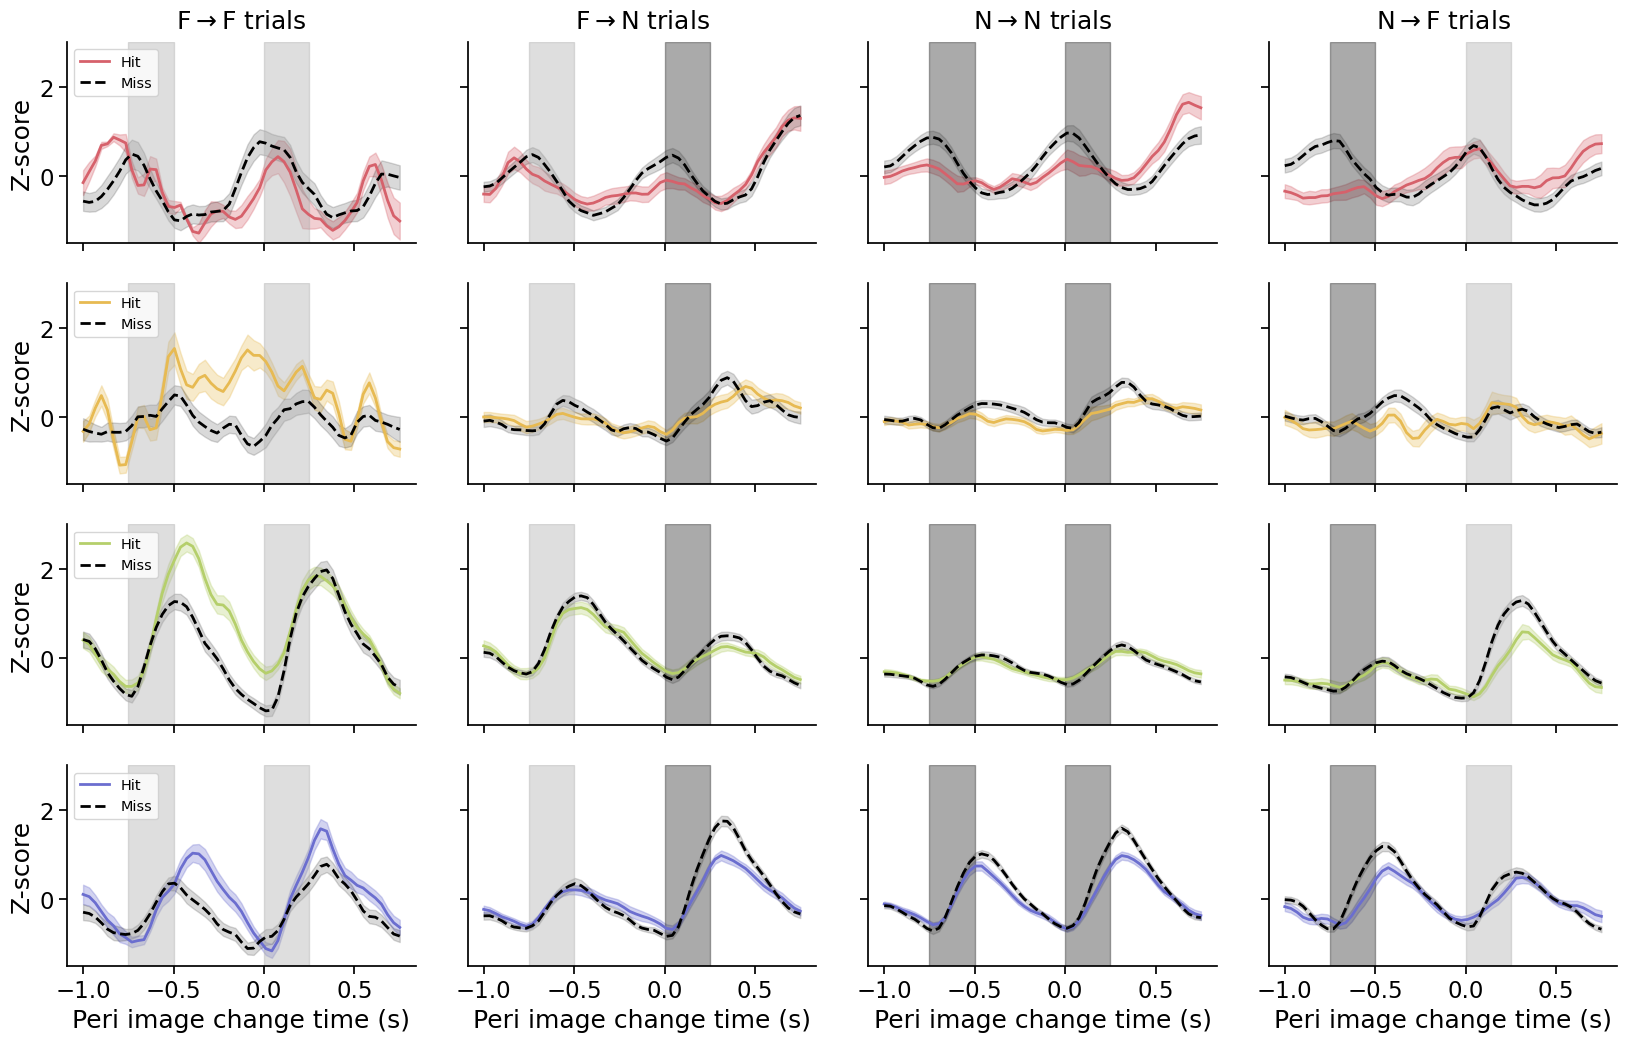

In [115]:
# Define the number of clusters
num_clusters = sorted_clustered_df.kmeans_labels.nunique()

# Plot events for all clusters: Z-score
fig, ax = plt.subplots(num_clusters, 4, figsize=(20, 3*num_clusters), sharey=True, sharex=True)
# Adjust spacing between subplots
fig.subplots_adjust(hspace=0.2, wspace=0.15)

hues = colors_clusters
c = sns.color_palette('Grays')
palette = [c[2], c[5]]
color_dict = {'F': palette[0], 'N': palette[1]}
mean_width = 2

# Loop over each cluster to create rows
for i, cluster_id in enumerate(sorted_clustered_df.kmeans_labels.unique()):
    # Get the relevant data
    cell_df = sorted_clustered_df[sorted_clustered_df.kmeans_labels == cluster_id]
    
    # Extract the z_hit and z_miss arrays
    dff_hit_array = np.array(cell_df['z_hit'].tolist())
    dff_hit_flat = dff_hit_array.reshape(len(cell_df.cell_specimen_id.unique()), -1)
    
    dff_miss_array = np.array(cell_df['z_miss'].tolist())
    dff_miss_flat = dff_miss_array.reshape(len(cell_df.cell_specimen_id.unique()), -1)
    
    # Calculate the mean and SEM for z_hit and z_miss
    mean_hit_trace = np.nanmean(dff_hit_flat, axis=0)
    sem_hit_trace = np.nanstd(dff_hit_flat, axis=0) / np.sqrt(dff_hit_flat.shape[0])
    
    mean_miss_trace = np.nanmean(dff_miss_flat, axis=0)
    sem_miss_trace = np.nanstd(dff_miss_flat, axis=0) / np.sqrt(dff_miss_flat.shape[0])
    
    # F:F
    ax[i, 0].plot(np.linspace(-1, 0.75, 53), mean_hit_trace[:53], color=hues[i], label='Hit', linewidth=mean_width)
    ax[i, 0].plot(np.linspace(-1, 0.75, 53), mean_miss_trace[:53], color='black', linestyle='--', label='Miss', linewidth=mean_width)
    ax[i, 0].fill_between(np.linspace(-1, 0.75, 53), mean_hit_trace[:53] - sem_hit_trace[:53], mean_hit_trace[:53] + sem_hit_trace[:53], color=hues[i], alpha=0.3)
    ax[i, 0].fill_between(np.linspace(-1, 0.75, 53), mean_miss_trace[:53] - sem_miss_trace[:53], mean_miss_trace[:53] + sem_miss_trace[:53], color='black', alpha=0.15)
    ax[i, 0].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)
    ax[i, 0].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)
    ax[i, 0].legend(loc='upper left', fontsize='xx-small')
    
    # F:N
    ax[i, 1].plot(np.linspace(-1, 0.75, 53), mean_hit_trace[53:106], color=hues[i], linewidth=mean_width)
    ax[i, 1].plot(np.linspace(-1, 0.75, 53), mean_miss_trace[53:106], color='black', linestyle='--', linewidth=mean_width)
    ax[i, 1].fill_between(np.linspace(-1, 0.75, 53), mean_hit_trace[53:106] - sem_hit_trace[53:106], mean_hit_trace[53:106] + sem_hit_trace[53:106], color=hues[i], alpha=0.3)
    ax[i, 1].fill_between(np.linspace(-1, 0.75, 53), mean_miss_trace[53:106] - sem_miss_trace[53:106], mean_miss_trace[53:106] + sem_miss_trace[53:106], color='black', alpha=0.15)
    ax[i, 1].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)
    ax[i, 1].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)
    
    # N:N
    ax[i, 2].plot(np.linspace(-1, 0.75, 53), mean_hit_trace[106:159], color=hues[i], linewidth=mean_width)
    ax[i, 2].plot(np.linspace(-1, 0.75, 53), mean_miss_trace[106:159], color='black', linestyle='--', linewidth=mean_width)
    ax[i, 2].fill_between(np.linspace(-1, 0.75, 53), mean_hit_trace[106:159] - sem_hit_trace[106:159], mean_hit_trace[106:159] + sem_hit_trace[106:159], color=hues[i], alpha=0.3)
    ax[i, 2].fill_between(np.linspace(-1, 0.75, 53), mean_miss_trace[106:159] - sem_miss_trace[106:159], mean_miss_trace[106:159] + sem_miss_trace[106:159], color='black', alpha=0.15)
    ax[i, 2].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)
    ax[i, 2].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)
    
    # N:F
    ax[i, 3].plot(np.linspace(-1, 0.75, 53), mean_hit_trace[159:], color=hues[i], linewidth=mean_width)
    ax[i, 3].plot(np.linspace(-1, 0.75, 53), mean_miss_trace[159:], color='black', linestyle='--', linewidth=mean_width)
    ax[i, 3].fill_between(np.linspace(-1, 0.75, 53), mean_hit_trace[159:] - sem_hit_trace[159:], mean_hit_trace[159:] + sem_hit_trace[159:], color=hues[i], alpha=0.3)
    ax[i, 3].fill_between(np.linspace(-1, 0.75, 53), mean_miss_trace[159:] - sem_miss_trace[159:], mean_miss_trace[159:] + sem_miss_trace[159:], color='black', alpha=0.15)
    ax[i, 3].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)
    ax[i, 3].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)
    
    # Set titles for each cluster row
    if i == 0:
        ax[i, 0].set_title(r'F$\rightarrow$F trials', pad=10)
        ax[i, 1].set_title(r'F$\rightarrow$N trials', pad=10)
        ax[i, 2].set_title(r'N$\rightarrow$N trials', pad=10)
        ax[i, 3].set_title(r'N$\rightarrow$F trials', pad=10)
        
    if i == num_clusters - 1:
        ax[i, 0].set_xlabel('Peri image change time (s)')
        ax[i, 1].set_xlabel('Peri image change time (s)')
        ax[i, 2].set_xlabel('Peri image change time (s)')
        ax[i, 3].set_xlabel('Peri image change time (s)')

# Adjust the y-axis limits and add labels to the first column of each row
for axis in ax.flatten():
    axis.set_ylim([z_min, z_max])
    axis.spines[['right', 'top']].set_visible(False)

for i in range(num_clusters):
    ax[i, 0].set_ylabel('Z-score')

# Save and display the plot
if save_plots==True:
    plt.savefig(genotype_image_path+'individual_clusters_z_averages_hit_vs_miss_trace.svg', format="svg")
plt.show()

# Look at behavior

In [116]:
# Merge curr_df with sorted_clustered_df on 'cell_specimen_id'
merged_df = curr_df.merge(sorted_clustered_df[['cell_specimen_id', 'kmeans_labels']], 
                       on='cell_specimen_id', 
                       how='left')

In [117]:
merged_df.columns

Index(['stimulus_presentations_id', 'cell_specimen_id', 'dff_trace',
       'trace_timestamps', 'dff_mean_response', 'dff_baseline_response',
       'p_value_gray_screen', 'ophys_frame_rate', 'data_type', 'event_type',
       ...
       'experience_level', 'prior_exposures_to_session_type',
       'prior_exposures_to_image_set', 'prior_exposures_to_omissions',
       'date_of_acquisition', 'equipment_name', 'published_at',
       'isi_experiment_id', 'file_id', 'kmeans_labels'],
      dtype='object', length=105)

In [118]:
# # Define the number of clusters
# num_clusters = sorted_clustered_df.kmeans_labels.nunique()

# # Plot events for all clusters: Z-score
# fig, ax = plt.subplots(num_clusters, 4, figsize=(20, 3*num_clusters), sharey=True, sharex=True)
# # Adjust spacing between subplots
# fig.subplots_adjust(hspace=0.2, wspace=0.15)

# hues = colors_clusters
# c = sns.color_palette('Grays')
# palette = [c[2], c[5]]
# color_dict = {'F': palette[0], 'N': palette[1]}
# mean_width = 2

# # Loop over each cluster to create rows
# for i, cluster_id in enumerate(sorted_clustered_df.kmeans_labels.unique()):
#     # Get the relevant data
#     cell_df = sorted_clustered_df[sorted_clustered_df.kmeans_labels == cluster_id]
    
#     # Extract the z_hit and z_miss arrays
#     dff_hit_array = np.array(cell_df['z_hit'].tolist())
#     dff_hit_flat = dff_hit_array.reshape(len(cell_df.cell_specimen_id.unique()), -1)
    
#     dff_miss_array = np.array(cell_df['z_miss'].tolist())
#     dff_miss_flat = dff_miss_array.reshape(len(cell_df.cell_specimen_id.unique()), -1)
    
#     # Calculate the mean and SEM for z_hit and z_miss
#     mean_hit_trace = np.mean(dff_hit_flat, axis=0)
#     sem_hit_trace = np.std(dff_hit_flat, axis=0) / np.sqrt(dff_hit_flat.shape[0])
    
#     mean_miss_trace = np.mean(dff_miss_flat, axis=0)
#     sem_miss_trace = np.std(dff_miss_flat, axis=0) / np.sqrt(dff_miss_flat.shape[0])
    
#     # F:F
#     ax[i, 0].plot(np.linspace(-1, 0.75, 53), mean_hit_trace[:53], color=hues[i], label='Hit', linewidth=mean_width)
#     ax[i, 0].plot(np.linspace(-1, 0.75, 53), mean_miss_trace[:53], color='black', linestyle='--', label='Miss', linewidth=mean_width)
#     ax[i, 0].fill_between(np.linspace(-1, 0.75, 53), mean_hit_trace[:53] - sem_hit_trace[:53], mean_hit_trace[:53] + sem_hit_trace[:53], color=hues[i], alpha=0.3)
#     ax[i, 0].fill_between(np.linspace(-1, 0.75, 53), mean_miss_trace[:53] - sem_miss_trace[:53], mean_miss_trace[:53] + sem_miss_trace[:53], color='black', alpha=0.15)
#     ax[i, 0].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)
#     ax[i, 0].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)
#     ax[i, 0].legend(loc='upper left', fontsize='xx-small')
    
#     # F:N
#     ax[i, 1].plot(np.linspace(-1, 0.75, 53), mean_hit_trace[53:106], color=hues[i], linewidth=mean_width)
#     ax[i, 1].plot(np.linspace(-1, 0.75, 53), mean_miss_trace[53:106], color='black', linestyle='--', linewidth=mean_width)
#     ax[i, 1].fill_between(np.linspace(-1, 0.75, 53), mean_hit_trace[53:106] - sem_hit_trace[53:106], mean_hit_trace[53:106] + sem_hit_trace[53:106], color=hues[i], alpha=0.3)
#     ax[i, 1].fill_between(np.linspace(-1, 0.75, 53), mean_miss_trace[53:106] - sem_miss_trace[53:106], mean_miss_trace[53:106] + sem_miss_trace[53:106], color='black', alpha=0.15)
#     ax[i, 1].axvspan(-0.75, -0.5, color=color_dict['F'], alpha=0.4)
#     ax[i, 1].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)
    
#     # N:N
#     ax[i, 2].plot(np.linspace(-1, 0.75, 53), mean_hit_trace[106:159], color=hues[i], linewidth=mean_width)
#     ax[i, 2].plot(np.linspace(-1, 0.75, 53), mean_miss_trace[106:159], color='black', linestyle='--', linewidth=mean_width)
#     ax[i, 2].fill_between(np.linspace(-1, 0.75, 53), mean_hit_trace[106:159] - sem_hit_trace[106:159], mean_hit_trace[106:159] + sem_hit_trace[106:159], color=hues[i], alpha=0.3)
#     ax[i, 2].fill_between(np.linspace(-1, 0.75, 53), mean_miss_trace[106:159] - sem_miss_trace[106:159], mean_miss_trace[106:159] + sem_miss_trace[106:159], color='black', alpha=0.15)
#     ax[i, 2].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)
#     ax[i, 2].axvspan(0, 0.25, color=color_dict['N'], alpha=0.4)
    
#     # N:F
#     ax[i, 3].plot(np.linspace(-1, 0.75, 53), mean_hit_trace[159:], color=hues[i], linewidth=mean_width)
#     ax[i, 3].plot(np.linspace(-1, 0.75, 53), mean_miss_trace[159:], color='black', linestyle='--', linewidth=mean_width)
#     ax[i, 3].fill_between(np.linspace(-1, 0.75, 53), mean_hit_trace[159:] - sem_hit_trace[159:], mean_hit_trace[159:] + sem_hit_trace[159:], color=hues[i], alpha=0.3)
#     ax[i, 3].fill_between(np.linspace(-1, 0.75, 53), mean_miss_trace[159:] - sem_miss_trace[159:], mean_miss_trace[159:] + sem_miss_trace[159:], color='black', alpha=0.15)
#     ax[i, 3].axvspan(-0.75, -0.5, color=color_dict['N'], alpha=0.4)
#     ax[i, 3].axvspan(0, 0.25, color=color_dict['F'], alpha=0.4)
    
#     # Set titles for each cluster row
#     if i == 0:
#         ax[i, 0].set_title(r'F$\rightarrow$F trials', pad=10)
#         ax[i, 1].set_title(r'F$\rightarrow$N trials', pad=10)
#         ax[i, 2].set_title(r'N$\rightarrow$N trials', pad=10)
#         ax[i, 3].set_title(r'N$\rightarrow$F trials', pad=10)
        
#     if i == num_clusters - 1:
#         ax[i, 0].set_xlabel('Peri image change time (s)')
#         ax[i, 1].set_xlabel('Peri image change time (s)')
#         ax[i, 2].set_xlabel('Peri image change time (s)')
#         ax[i, 3].set_xlabel('Peri image change time (s)')

# # Adjust the y-axis limits and add labels to the first column of each row
# for axis in ax.flatten():
#     axis.set_ylim([z_min, z_max])
#     axis.spines[['right', 'top']].set_visible(False)

# for i in range(num_clusters):
#     ax[i, 0].set_ylabel('Z-score')

# # Save and display the plot
# if save_plots==True:
#     plt.savefig(genotype_image_path+'individual_clusters_z_averages_hit_vs_miss_trace.svg', format="svg")
# plt.show()

# Look at first 5 vs last 5 trials

In [119]:
curr_df

stimulus_presentations_id  cell_specimen_id  \
2464                          41        1120052112   
2473                          69        1120052112   
2482                          81        1120052112   
2491                         179        1120052112   
2500                         203        1120052112   
...                          ...               ...   
15075                       4753        1120130489   
15079                       4764        1120130489   
15083                       4774        1120130489   
15087                       4785        1120130489   
15091                       4796        1120130489   

                                               dff_trace  \
2464   [0.042259880394613536, 0.042259880394613536, 0...   
2473   [0.048287522071245884, 0.03638492400355589, 0....   
2482   [0.005541237570633933, 0.005541237570633933, -...   
2491   [0.18972879164401918, 0.17715864134070483, 0.1...   
2500   [-0.030616664174032818, -0.03231775403972199, ...   
...                                                  ...   
15075  [-0.06150301673691807, -0.06150301673691807, -...   
15079  [0.102349889779344, 0.102349889779344, 0.10234...   
15083  [-0.04169246631282179, -0.04169246631282179, -...   
15087  [0.04995117836145415, 0.04995117836145415, 0.0...   
15091  [-0.27831276244165143, -0.2366632132887583, -0...   

                                        trace_timestamps  dff_mean_response  \
2464   [-1.0, -0.9666666666666667, -0.933333333333333...           0.087415   
2473   [-1.0, -0.9666666666666667, -0.933333333333333...           0.021839   
2482   [-1.0, -0.9666666666666667, -0.933333333333333...           0.245046   
2491   [-1.0, -0.9666666666666667, -0.933333333333333...           0.079460   
2500   [-1.0, -0.9666666666666667, -0.933333333333333...           0.006527   
...                                                  ...                ...   
15075  [-1.0, -0.9666666666666667, -0.933333333333333...          -0.010764   
15079  [-1.0, -0.9666666666666667, -0.933333333333333...          -0.056426   
15083  [-1.0, -0.9666666666666667, -0.933333333333333...          -0.042243   
15087  [-1.0, -0.9666666666666667, -0.933333333333333...           0.028365   
15091  [-1.0, -0.9666666666666667, -0.933333333333333...          -0.072159   

       dff_baseline_response  p_value_gray_screen  ophys_frame_rate data_type  \
2464                0.021557               0.0394                30       dff   
2473                0.004380               0.3937                30       dff   
2482               -0.079510               0.0000                30       dff   
2491                0.153995               0.0417                30       dff   
2500                0.017416               0.6706                30       dff   
...                      ...                  ...               ...       ...   
15075               0.096618               1.0000                30       dff   
15079              -0.040606               1.0000                30       dff   
15083               0.041728               1.0000                30       dff   
15087              -0.060068               0.5431                30       dff   
15091               0.007526               1.0000                30       dff   

      event_type  ...  passive  experience_level  \
2464     changes  ...    False           Novel 1   
2473     changes  ...    False           Novel 1   
2482     changes  ...    False           Novel 1   
2491     changes  ...    False           Novel 1   
2500     changes  ...    False           Novel 1   
...          ...  ...      ...               ...   
15075    changes  ...    False           Novel 1   
15079    changes  ...    False           Novel 1   
15083    changes  ...    False           Novel 1   
15087    changes  ...    False           Novel 1   
15091    changes  ...    False           Novel 1   

       prior_exposures_to_session_type prior_exposures_to_image_set  \
2464               

In [120]:
sorted_clustered_df

targeted_structure_id  cell_specimen_id  \
11                       1        1120053554   
84                       1        1120122404   
92                       1        1120124516   
126                      1        1120125675   
130                      1        1120126155   
..                     ...               ...   
55                       4        1120091999   
56                       4        1120092108   
59                       4        1120092511   
62                       4        1120092688   
66                       4        1120092851   

                                     df_kmeans  \
11     [-8.47868569842982, -8.655599567692438]   
84    [-5.805814265051368, -9.265807308328553]   
92   [-5.6468861128755075, -5.491706815434981]   
126  [-14.418331788743412, -6.489171615479315]   
130  [-14.959330119859837, -4.787356556037022]   
..                                         ...   
55     [-6.400451137921705, 6.654845547707983]   
56      [-4.756241926668404, 5.58629080681047]   
59    [-0.3706143703415759, 4.826687166675307]   
62    [-2.405672250088277, 3.8865184212176636]   
66      [-2.7172419697513104, 4.2823275004189]   

                                                 z_all  \
11   [0.833858721472362, 0.7968002427861389, 0.7327...   
84   [-0.44780069790362426, -0.45192214382382867, -...   
92   [-0.9688428935726376, -1.115763279793347, -1.6...   
126  [-0.9322023764034575, -0.89323626764562, -0.66...   
130  [-1.5901059517282856, -1.5679937962513084, -1....   
..                                                 ...   
55   [1.254634677611655, 0.9057263544868059, 0.3398...   
56   [-0.5550142958208603, -0.2613364366653201, -0....   
59   [1.201153232576373, 0.9514534363513857, 0.5039...   
62   [-1.3750511352959351, -0.954445675525962, -0.3...   
66   [-1.2752123568354983, -0.7942181319137935, -0....   

                                                 z_hit  \
11   [1.9640064182302033, 1.813683304774047, 1.2986...   
84   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
92   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
126  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
130  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
..                                                 ...   
55   [2.5836583519412297, 2.1437333961239506, 1.415...   
56   [0.33609936204223123, 0.9314291962543751, 1.44...   
59   [1.0929351420179292, 0.7005703031389885, -0.09...   
62   [0.3698525567817714, 0.3992975146104645, 0.427...   
66   [0.12667635851173684, 0.8028026014143617, 1.35...   

                                                z_miss  \
11   [-1.9035029044489764, -1.914085219994519, -1.7...   
84   [0.3382180629552784, 0.33235083882102223, 0.58...   
92   [-0.4836496333978217, -0.6388461614142604, -1....   
126  [-1.0311407600570033, -0.9902982824610377, -0....   
130  [-1.6261100741518277, -1.6047775738209515, -1....   
..                                                 ...   
55   [0.012194416956425291, -0.24921751429216685, -...   
56   [-1.3279359113953066, -1.2306709978479562, -1....   
59   [1.8321312815853623, 1.7111078396597188, 1.559...   
62   [-2.9675493297797924, -2.1918611682984803, -1....   
66   [-1.3937719663835162, -0.9888686510151795, -0....   

     kmeans_labels_unsorted  \
11                        2   
84                        2   
92                        2   
126                       2   
130                       2   
..                      ...   
55                        3   
56                        3   
59                        3   
62                        3   
66                        3   

                                               dff_all  \
11   [[0.10957244910322562, 0.10695128679009944, 0....   
84   [[0.01286674250617398, 0.01268385058861727, 0....   
92   [[-0.009976376429762714, -0.012293108772506637...   
126  [[0.049231887391201046, 0.06814223805542569, 0...   
130  [[0.43529149777291626, 0.44873691633182217, 0....   
..             

In [121]:
merged_df

stimulus_presentations_id  cell_specimen_id  \
0                             41        1120052112   
1                             69        1120052112   
2                             81        1120052112   
3                            179        1120052112   
4                            203        1120052112   
...                          ...               ...   
48481                       4753        1120130489   
48482                       4764        1120130489   
48483                       4774        1120130489   
48484                       4785        1120130489   
48485                       4796        1120130489   

                                               dff_trace  \
0      [0.042259880394613536, 0.042259880394613536, 0...   
1      [0.048287522071245884, 0.03638492400355589, 0....   
2      [0.005541237570633933, 0.005541237570633933, -...   
3      [0.18972879164401918, 0.17715864134070483, 0.1...   
4      [-0.030616664174032818, -0.03231775403972199, ...   
...                                                  ...   
48481  [-0.06150301673691807, -0.06150301673691807, -...   
48482  [0.102349889779344, 0.102349889779344, 0.10234...   
48483  [-0.04169246631282179, -0.04169246631282179, -...   
48484  [0.04995117836145415, 0.04995117836145415, 0.0...   
48485  [-0.27831276244165143, -0.2366632132887583, -0...   

                                        trace_timestamps  dff_mean_response  \
0      [-1.0, -0.9666666666666667, -0.933333333333333...           0.087415   
1      [-1.0, -0.9666666666666667, -0.933333333333333...           0.021839   
2      [-1.0, -0.9666666666666667, -0.933333333333333...           0.245046   
3      [-1.0, -0.9666666666666667, -0.933333333333333...           0.079460   
4      [-1.0, -0.9666666666666667, -0.933333333333333...           0.006527   
...                                                  ...                ...   
48481  [-1.0, -0.9666666666666667, -0.933333333333333...          -0.010764   
48482  [-1.0, -0.9666666666666667, -0.933333333333333...          -0.056426   
48483  [-1.0, -0.9666666666666667, -0.933333333333333...          -0.042243   
48484  [-1.0, -0.9666666666666667, -0.933333333333333...           0.028365   
48485  [-1.0, -0.9666666666666667, -0.933333333333333...          -0.072159   

       dff_baseline_response  p_value_gray_screen  ophys_frame_rate data_type  \
0                   0.021557               0.0394                30       dff   
1                   0.004380               0.3937                30       dff   
2                  -0.079510               0.0000                30       dff   
3                   0.153995               0.0417                30       dff   
4                   0.017416               0.6706                30       dff   
...                      ...                  ...               ...       ...   
48481               0.096618               1.0000                30       dff   
48482              -0.040606               1.0000                30       dff   
48483               0.041728               1.0000                30       dff   
48484              -0.060068               0.5431                30       dff   
48485               0.007526               1.0000                30       dff   

      event_type  ...  experience_level  prior_exposures_to_session_type  \
0        changes  ...           Novel 1                                0   
1        changes  ...           Novel 1                                0   
2        changes  ...           Novel 1                                0   
3        changes  ...           Novel 1                                0   
4        changes  ...           Novel 1                                0   
...          ...  ...               ...                              ...   
48481    changes  ...           Novel 1                                0   
48482    changes  ...           Novel 1                                0   
48483    changes  ...          